In [102]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, random, praw, csv
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
import re, urllib

from pathlib import Path
from datetime import datetime
import logging

utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/nathan/CivilServant"
FILE_BASE_DIR="/home/nathan/reddit_archive/"
sys.path.append(BASE_DIR)
subreddit_id = "2qr7i"

LOG_PATH = str(Path(BASE_DIR, "logs", "praw_messenger_%s.log" % ENV))
logging.basicConfig(filename=LOG_PATH, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

ARCHIVE_DIR = "/home/nathan/reddit_archive/03.2017"

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, and_, or_
from app.models import Base, SubredditPage, FrontPage, Subreddit, Post, ModAction, Experiment
from utils.common import PageType

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR)
r = conn.connect(use_db_keys=False)

#notebook_dir = os.getcwd()
#os.chdir(notebook_dir)
#import praw.errors


### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
#import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json


# Sample Recent r/feminism newcomer commenters

### Data integrity checks and load background data

In [93]:
## LOOK AT HOW RECENT OUR COMMENTS DATASET IS (HOPE THAT WE HAVE ALL THE WAY TO THE BEGINNING OF MARCH)
## LOOK AT HOW RECENT OUR SUBMISSIONS DATASET IS (HOPE THAT WE HAVE ALL THE WAY TO THE BEGINNING OF MARCH)

## CONSTRUCT A MEASURE OF THE SIX MONTH WINDOW (FROM Feminism Newcomer Analysis)

In [94]:
begin_date = '2018-03-01'
query_text = """
select * from comments 
    WHERE subreddit_id = '2qr7i'
    AND created_at >= {begin_date}
    ORDER BY created_utc ASC;
""".format(begin_date = begin_date)

## ADDED THE SECOND CREATED_AT TO PRESERVE EXPERIMENT INTEGRITY

database_comments = []

for row in db_engine.execute(text(query_text)):
    comment = {}
    comment_data = json.loads(row['comment_data'])
    for key in comment_data.keys():
        comment[key] = comment_data[key]
    for key in row.keys():
        comment[key]=row[key]
    comment['created'] = comment['created_utc']
    database_comments.append(comment)
    
print("Loaded {0} Comments".format(len(database_comments)))

Loaded 8061 Comments


In [95]:
file_comments = []
comment_ids = set()
comment_count = 0

comments_filename="full_feminism_comments_through_02_2018.json"

with open(os.path.join(FILE_BASE_DIR, "selected_output", comments_filename), "r") as f:
    for line in f:
        item = json.loads(line)
        if(item['id'] not in comment_ids):
            item['created'] = datetime.utcfromtimestamp(float(item['created_utc']))
            item['body.charlength'] = len(item['body'])
            #item['body'] = None
            file_comments.append(item)
            comment_ids.add(item['id'])
        comment_count += 1
#file_comments = sorted(file_comments, key = lambda x: x['created'])        

print("Loaded {0} Comments".format(len(file_comments)))
print("Loaded {0} Comment lines".format(comment_count))

Loaded 85412 Comments
Loaded 90555 Comment lines


### Add database comments to file-loaded comments

In [6]:
keys_to_include = []
for key in file_comments[0].keys():
    if key in database_comments[0].keys():
        keys_to_include.append(key)
#print("Keys in file and in database: [{0}]".format((",").join(keys_to_skip)))


all_comments = file_comments

added_comment_ids = 0
duplicate_comment_ids = 0

for comment in database_comments:
    if comment['id'] not in comment_ids:
        trimmed_comment = {}
        for key in keys_to_include:
            trimmed_comment[key] = comment[key]
        all_comments.append(trimmed_comment)
        comment_ids.add(comment['id'])
        added_comment_ids += 1
    else:
        duplicate_comment_ids += 1
print("Merged comment datasets. Added {0} comments and skipped {1} duplicates".format(
    added_comment_ids, duplicate_comment_ids))

## NOW SORT COMMENTS
all_comments = sorted(all_comments, key = lambda x: x['created'])        

Merged comment datasets. Added 7088 comments and skipped 148 duplicates


### Record the number of previous comments that a participant made in the prior six months

In [7]:
def previous_actions():
    return {"comments":[], "posts":[]}

author_records = defaultdict(previous_actions)

for item in all_comments:
    author_id = item['author']
    author_records[author_id]['comments'].append(item)

#one_eighty_days in seconds
def count_if_eligible(current, comparator):
    one_eighty_days = 60*60*24*180
    if(current['created'] > comparator['created'] and 
       (current['created'] - comparator['created']).total_seconds()<one_eighty_days):
        return 1
    return 0

earliest_date = all_comments[0]['created']

sys.stdout.write("\ncomments")
sys.stdout.flush()
items_processed = 0
for item in all_comments:
    previous_comments = 0
    for comment in author_records[item['author']]['comments']:
        if(item['created'] > comment['created']):
            previous_comments += count_if_eligible(item, comment) 
    items_processed += 1
    item['previous.comments'] = previous_comments
    item['eligible'] = item['created'] > earliest_date
    
    if(items_processed % 1000 == 0):
        sys.stdout.write(".")
        sys.stdout.flush()
    


comments............................................................................................

# Create a Sample of Recent Commenters 
First time commenters within the last 45 days

In [8]:
recent_comment_in_seconds = 60*60*24*45
current_time = datetime.utcnow()

In [9]:
eligible_comments = [x for x in all_comments if x['eligible'] and 
                      (current_time - x['created']).total_seconds() < recent_comment_in_seconds and
                      x['previous.comments']==0]

print("Total comments: {0}. Eligible comments: {1}".format(
    len(all_comments),
    len(eligible_comments)))

Total comments: 92500. Eligible comments: 1632


### Label comments by how many weeks previously they commented for the first time (for a stratified random sample)

In [10]:
one_week_in_seconds = 60*60*24*7

for comment in eligible_comments:
    comment['first.comment.week.diff'] = int((current_time - comment['created']).total_seconds() / 
                                             one_week_in_seconds)
    
    
    

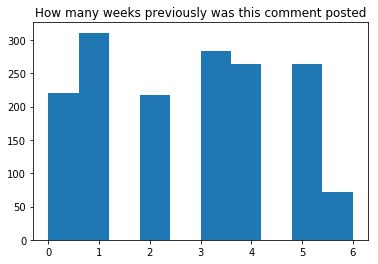

In [11]:
plt.hist([comment['first.comment.week.diff'] for comment in eligible_comments])
plt.title("How many weeks previously was this comment posted")
plt.show()

### Create a stratified random sample of accounts to message, based on the elapsed number of weeks since they originally posted their first comment
Later, we may want to do a post-hoc analysis of how many comments they had previously made in the subreddit. Note that we will want to include them int he sample even if their account doesn't exist, because we're going to be including those kinds of accounts in the study, and we will want to think about that attrition as an expected part of the sample.

In [12]:
eligible_by_week = {}
for key in set([x['first.comment.week.diff'] for x in eligible_comments]):
    eligible_by_week[key] = [x['author'] for x in eligible_comments if 
                             x['first.comment.week.diff'] == key]

In [13]:
for key in sorted(eligible_by_week.keys()):
    print("Week age {0}: {1} authors ".format(key, len(eligible_by_week[key])))

Week age 0: 220 authors 
Week age 1: 311 authors 
Week age 2: 217 authors 
Week age 3: 284 authors 
Week age 4: 264 authors 
Week age 5: 264 authors 
Week age 6: 72 authors 


In [40]:
##  Decision: survey 100 authors per group
##  Only survey the last 4 weeks
random.seed(880442) # current milliseconds at code time
sample_size = 100
selected_by_week = {}
for week in sorted(eligible_by_week.keys()):
    if week <=4:
        selected_by_week[week] = random.sample(eligible_by_week[week], sample_size)
        
for week in sorted(selected_by_week.keys()):
    print("Week age {0}: {1} authors ".format(week, len(selected_by_week[week])))

Week age 0: 100 authors 
Week age 1: 100 authors 
Week age 2: 100 authors 
Week age 3: 100 authors 
Week age 4: 100 authors 


['Mr_Saturn_Valley',
 'xydroh',
 'ZenIsNotChosen',
 'NathanRav',
 'cadhlacrude',
 'jnb64',
 'jenrd',
 'dark_side_of_pluto',
 'eliechallita',
 'TGP2005',
 'iamlikeanonion',
 'Europesupportsrape',
 'inoahguy98',
 'cierachanyel',
 'GrandAce',
 'ejoburke90',
 'water_vapour',
 'Original_Castor_Troy',
 'aardBot',
 'Swarmingvulture',
 'Kusariiii',
 'LauraTFem',
 'banannercler',
 'philotorzar',
 'CJ10002000',
 'Jen909',
 'Nitro-Nipples',
 'Plyad1',
 'Parsparis',
 'forestheart13',
 'ronmoss-',
 'dgcrew',
 'etherealoceanbaby',
 'misanthropester',
 'liusual',
 '120kRolex',
 'sarahsilverxo',
 'LilMadoka',
 'Ep1cDuCK',
 'ENrocket',
 'noah1754',
 'Tankpiggy',
 'quagley',
 'A_Lady_Loves',
 'Bulmas_Panties',
 'POOTISFAIRY',
 'rmrfpatriarchy',
 'Ojoojoji',
 'wildronin1129',
 'seddfu',
 'elijahtkitty',
 'TheOneFreeEngineer',
 'twitchingJay',
 'TheLovelyLorelei',
 'VanillaMonster',
 'PhatTaco',
 'bromelliad',
 'lil_tea_bag',
 'Cardoba',
 'TheBloxdude',
 'Beltch',
 'Fatsolamb22',
 'silvastacka',
 'Mazza11

# Construct and personalize the message

## Construct the message template

In [32]:
MESSAGE_SUBJECT = "Welcome! Help r/feminism understand first-time commenters with 3 questions"
MESSAGE_TEMPLATE = """Dear {username},

Hello and welcome from r/feminism! 

Might you answer a 2 minute, 3-question survey to help us learn more about your experience? We're' currently working with researchers at Princeton University to improve newcomer experiences.

[Learn more and answer the survey here]({url}). Thanks! 

-- [CivilServant](http://civilservant.io/) and the [r/feminism moderators](https://www.reddit.com/r/feminism/about/moderators)
"""

In [33]:
print(MESSAGE_TEMPLATE.format(username="natematias", 
                              url="https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409={username}&entry.1933578897".format(
                              username="natematias")))

Dear natematias,

Hello and welcome from r/feminism! 

Might you answer a 2 minute, 3-question survey to help us learn more about your experience? We're' currently working with researchers at Princeton University to improve newcomer experiences.

[Learn more and answer the survey here](https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=natematias&entry.1933578897). Thanks! 

-- [CivilServant](http://civilservant.io/) and the [r/feminism moderators](https://www.reddit.com/r/feminism/about/moderators)



In [17]:
r.send_message("natematias", MESSAGE_SUBJECT, MESSAGE_TEMPLATE.format(username="natematias"))

## Add the ability to validate users

In [53]:
def get_reddit_user(username):
    try:
        user_dict = r.get_redditor(username, fetch=True).json_dict
        logging.info("User %s found: %s" %(username, str(user_dict)))
        return user_dict
    except praw.errors.NotFound as e:
        logging.error("User not found: %s" % username)
    except Exception as e:
        logging.exception("Failed to retrieve user")

In [54]:
import time
send_log_dir = "/home/nathan/CivilServant-Analysis/SOC412/feminism"
send_log_filename = "message_sender_feminism_04_17_2018.csv"
def sent_message_previously(username):
    with open(os.path.join(send_log_dir, send_log_filename), "r") as f:
        send_log = []
        for row in csv.DictReader(f):
            send_log.append(row)
            if(username == row['username']):
                return True
    return False

## Add the ability to send messages

In [55]:
## RETURN TRUE IF MESSAGE WAS SENT SUCCESSFULLY
def send_reddit_message(**message_data):
    user = message_data["username"]    
    message = MESSAGE_TEMPLATE.format(**message_data)    
    try:
        logging.info("Sending a message to user %s with data %s" % (user, str(message_data)))
        response = r.send_message(user, MESSAGE_SUBJECT, message, raise_captcha_exception=True)
        if response["errors"]:
            logging.error("Error in response when sending a message to user %s: %s" % (user, str(response)))
            return False
        else:
            logging.info("Message successfully sent to user %s" % user)
            return True
    except praw.errors.InvalidCaptcha as e:
        logging.exception("Message sending requires a captcha")
        logging.error(e.response)
        return False
    except Exception as e:
        logging.exception("Failed to send message to %s" % user)
        return False

## Wrap the messenger function with anything survey-specific

In [56]:
def send_survey_message(**message_data):
    message = MESSAGE_TEMPLATE.format(**message_data)        
    sent_status = send_reddit_message(**message_data)
    with open(os.path.join(send_log_dir,send_log_filename), "a") as f:
        print("APPENDING TO FILE: {0}".format(message_data))
        f.write(",".join(map(str, [
            message_data['username'],
            True, #account exists
            message_data['get_info_date'],
            message_data['deleted'],
            message_data['url'],
            message_data['first_comment_week'],
            sent_status
        ])) + "\n")
        f.close()
    
    logging.info("first_comment_week: %s" % message_data["first_comment_week"])
    logging.info("url: %s" % message_data["url"])
    logging.info("get_info_data: %s" % message_data["get_info_date"])
    logging.info("deleted: %s" % message_data["deleted"])
    

In [63]:
def decide_and_send_to_user(username, first_comment_week):
    if(sent_message_previously(username)):
        logging.info("User %s previously received a message" % username)
        return None
    else:
        time.sleep(2)
        user = get_reddit_user(username)

    if user:
        send_survey_message(
            username = username,
            first_comment_week = first_comment_week,
            get_info_date = str(datetime.utcnow()),
            deleted = False,
            url = "https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409={username}&entry.1933578897".format(
                username=username))
    else:
        with open(os.path.join(send_log_dir, send_log_filename), "a") as f:
            f.write(",".join(map(str, [
                username,
                False,
                str(datetime.utcnow()),
                None,
                None,
                first_comment_week,
                False
            ])) + "\n")
            f.close()

In [115]:
## TEST SENDING
#decide_and_send_to_user("natematias", 1)
sum([len(x) for x in selected_by_week.values()])

500

# Send Surveys to Participants

In [65]:
# import time
# for week in sorted(selected_by_week.keys()):
#     print("Week age {0}: {1} authors ".format(week, len(selected_by_week[week])))
#     for username in selected_by_week[week]:
#         decide_and_send_to_user(username, week)

Week age 0: 100 authors 
User Mr_Saturn_Valley previously received a message
User xydroh previously received a message
User ZenIsNotChosen previously received a message
User NathanRav previously received a message
User cadhlacrude previously received a message
User jnb64 previously received a message
User jenrd previously received a message
User dark_side_of_pluto previously received a message
User eliechallita previously received a message
User TGP2005 previously received a message
User iamlikeanonion previously received a message
User Europesupportsrape previously received a message
User inoahguy98 previously received a message
User cierachanyel previously received a message
User GrandAce previously received a message
User ejoburke90 previously received a message
User water_vapour previously received a message
User Original_Castor_Troy previously received a message
User aardBot previously received a message
User Swarmingvulture previously received a message
User Kusariiii previously 

User tacosaladchupacabra previously received a message
User Anna_Kissed previously received a message
User punpuniq previously received a message
User rom1bki previously received a message
User mspk7305 previously received a message
User DoraForscher previously received a message
User ___DOUBLETROUBLE___ previously received a message
User timwellens previously received a message
User oogaboogaHS previously received a message
User shrewms previously received a message
User BeauHovey24 previously received a message
User Cohen_TheBarbarian previously received a message
User totoyakatiyo previously received a message
User Thatwasmint previously received a message
User OgonnaMadonna previously received a message
User Xx9ine6ix previously received a message
User HumanityMasterRace previously received a message
User Maysock previously received a message
User damsel-inadress previously received a message
User scoobyMcdoobyfry previously received a message
User balthazartoad previously received

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/LiberalGeneral79/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user LiberalGeneral79
APPENDING TO FILE: {'username': 'LiberalGeneral79', 'get_info_date': '2018-04-17 13:43:56.549798', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=LiberalGeneral79&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=LiberalGeneral79&entry.1933578897
get_info_data: 2018-04-17 13:43:56.549798
deleted: False
User wusgoodbee found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_FFB000.png', 'is_employee': False, 'comment_karma': 2590, 'name': 'wusgoodbee', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_5ub8w', 'u

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/wusgoodbee/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user wusgoodbee
APPENDING TO FILE: {'username': 'wusgoodbee', 'get_info_date': '2018-04-17 13:44:00.707694', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=wusgoodbee&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=wusgoodbee&entry.1933578897
get_info_data: 2018-04-17 13:44:00.707694
deleted: False
User futuresquid found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_FF4500.png', 'is_employee': False, 'comment_karma': 1685, 'name': 'futuresquid', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '14xjuc', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1485849440.

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/futuresquid/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user futuresquid
APPENDING TO FILE: {'username': 'futuresquid', 'get_info_date': '2018-04-17 13:44:04.831510', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=futuresquid&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=futuresquid&entry.1933578897
get_info_data: 2018-04-17 13:44:04.831510
deleted: False
User Scrotom found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_0079D3.png', 'is_employee': False, 'comment_karma': 13978, 'name': 'Scrotom', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_aluzo', 'user_is_moderator': False,

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Scrotom/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Scrotom
APPENDING TO FILE: {'username': 'Scrotom', 'get_info_date': '2018-04-17 13:44:09.082760', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Scrotom&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Scrotom&entry.1933578897
get_info_data: 2018-04-17 13:44:09.082760
deleted: False
User meat_tunnel found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_A06A42.png', 'is_employee': False, 'comment_karma': 78027, 'name': 'meat_tunnel', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'x9u2v', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1461028578.0, 'created_u

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/meat_tunnel/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user meat_tunnel
APPENDING TO FILE: {'username': 'meat_tunnel', 'get_info_date': '2018-04-17 13:44:13.338256', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=meat_tunnel&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=meat_tunnel&entry.1933578897
get_info_data: 2018-04-17 13:44:13.338256
deleted: False
User PippyDickling found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_94E044.png', 'is_employee': False, 'comment_karma': 2663, 'name': 'PippyDickling', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_5ps8o', 'user_is_moderat

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/PippyDickling/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user PippyDickling
APPENDING TO FILE: {'username': 'PippyDickling', 'get_info_date': '2018-04-17 13:44:17.499515', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PippyDickling&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PippyDickling&entry.1933578897
get_info_data: 2018-04-17 13:44:17.499515
deleted: False
User noisefloor66 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_C18D42.png', 'is_employee': False, 'comment_karma': -1, 'name': 'noisefloor66', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_hdw2n', 'user_is_mod

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/noisefloor66/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user noisefloor66
APPENDING TO FILE: {'username': 'noisefloor66', 'get_info_date': '2018-04-17 13:44:21.693344', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=noisefloor66&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=noisefloor66&entry.1933578897
get_info_data: 2018-04-17 13:44:21.693344
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/JizzClown/about/.json


User JizzClown found: {'name': 'JizzClown', 'is_suspended': True}
Sending a message to user JizzClown with data {'first_comment_week': 2, 'username': 'JizzClown', 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=JizzClown&entry.1933578897', 'deleted': False, 'get_info_date': '2018-04-17 13:44:25.960476'}


substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user JizzClown
APPENDING TO FILE: {'username': 'JizzClown', 'get_info_date': '2018-04-17 13:44:25.960476', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=JizzClown&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=JizzClown&entry.1933578897
get_info_data: 2018-04-17 13:44:25.960476
deleted: False
User stone_opera found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_A06A42.png', 'is_employee': False, 'comment_karma': 66395, 'name': 'stone_opera', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 's5mwe', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1447868865.0, 'c

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/stone_opera/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user stone_opera
APPENDING TO FILE: {'username': 'stone_opera', 'get_info_date': '2018-04-17 13:44:30.239891', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=stone_opera&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=stone_opera&entry.1933578897
get_info_data: 2018-04-17 13:44:30.239891
deleted: False
User mcxclo found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_17_7193FF.png', 'is_employee': False, 'comment_karma': 1, 'name': 'mcxclo', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gqwk6', 'user_is_moderator': False, 'comm

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/mcxclo/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user mcxclo
APPENDING TO FILE: {'username': 'mcxclo', 'get_info_date': '2018-04-17 13:44:34.621396', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mcxclo&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mcxclo&entry.1933578897
get_info_data: 2018-04-17 13:44:34.621396
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/CallMeCasual/about/.json


User CallMeCasual found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_A06A42.png', 'is_employee': False, 'comment_karma': 104, 'name': 'CallMeCasual', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_cgawm', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/CallMeCasual/', 'description': '', 'display_name_prefixed': 'u/CallMeCasual', 'subscribers': 0, 'display_name': 'u_CallMeCasual', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_A06A42.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#A06A42', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False,

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user CallMeCasual
APPENDING TO FILE: {'username': 'CallMeCasual', 'get_info_date': '2018-04-17 13:44:38.970340', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CallMeCasual&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CallMeCasual&entry.1933578897
get_info_data: 2018-04-17 13:44:38.970340
deleted: False
User hitemplo found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_7nwwv/styles/communityIcon_i2zhlwi8sjd01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=335dea3a6c8b6a6e6ad44a8793131bf3', 'is_employee': False, 'comment_karma': 2013, 'name': 'hitemplo', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'lin

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/hitemplo/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user hitemplo
APPENDING TO FILE: {'username': 'hitemplo', 'get_info_date': '2018-04-17 13:44:43.049829', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=hitemplo&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=hitemplo&entry.1933578897
get_info_data: 2018-04-17 13:44:43.049829
deleted: False
User qyke found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_4856A3.png', 'is_employee': False, 'comment_karma': 234, 'name': 'qyke', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gz4f6', 'user_is_moderator': False, 'community_icon': '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/qyke/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user qyke
APPENDING TO FILE: {'username': 'qyke', 'get_info_date': '2018-04-17 13:44:47.296443', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=qyke&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=qyke&entry.1933578897
get_info_data: 2018-04-17 13:44:47.296443
deleted: False
User SweetBakchich found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_25B79F.png', 'is_employee': False, 'comment_karma': 1132, 'name': 'SweetBakchich', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '1194kz', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1473319702.0, 'created_utc': 147

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/SweetBakchich/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user SweetBakchich
APPENDING TO FILE: {'username': 'SweetBakchich', 'get_info_date': '2018-04-17 13:44:51.411729', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SweetBakchich&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SweetBakchich&entry.1933578897
get_info_data: 2018-04-17 13:44:51.411729
deleted: False
User MisterUri found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_4856A3.png', 'is_employee': False, 'comment_karma': 1933, 'name': 'MisterUri', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '8sm9x', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 134603

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/MisterUri/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user MisterUri
APPENDING TO FILE: {'username': 'MisterUri', 'get_info_date': '2018-04-17 13:44:55.629600', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MisterUri&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MisterUri&entry.1933578897
get_info_data: 2018-04-17 13:44:55.629600
deleted: False
User evilmomlady found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_008985.png', 'is_employee': False, 'comment_karma': 693, 'name': 'evilmomlady', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '156wg1', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1486566092.0, 'cr

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/evilmomlady/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user evilmomlady
APPENDING TO FILE: {'username': 'evilmomlady', 'get_info_date': '2018-04-17 13:44:59.841567', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=evilmomlady&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=evilmomlady&entry.1933578897
get_info_data: 2018-04-17 13:44:59.841567
deleted: False
User genitame found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_46D160.png', 'is_employee': False, 'comment_karma': 13570, 'name': 'genitame', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'dc5kn', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1380597411.0,

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/genitame/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user genitame
APPENDING TO FILE: {'username': 'genitame', 'get_info_date': '2018-04-17 13:45:04.005128', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=genitame&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=genitame&entry.1933578897
get_info_data: 2018-04-17 13:45:04.005128
deleted: False
User sircontagious found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_7E53C1.png', 'is_employee': False, 'comment_karma': 123, 'name': 'sircontagious', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_b03vi', 'user_is_moderator': False, '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sircontagious/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user sircontagious
APPENDING TO FILE: {'username': 'sircontagious', 'get_info_date': '2018-04-17 13:45:08.194688', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sircontagious&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sircontagious&entry.1933578897
get_info_data: 2018-04-17 13:45:08.194688
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/chilipepper50/about/.json


User chilipepper50 found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_cij5e/styles/profileIcon_w2rw1lzoupq01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=a8def6fd528c318782b82612c8ab8b70', 'is_employee': False, 'comment_karma': 11556, 'name': 'chilipepper50', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_cij5e', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/chilipepper50/', 'description': '', 'display_name_prefixed': 'u/chilipepper50', 'subscribers': 0, 'display_name': 'u_chilipepper50', 'user_is_banned': False, 'is_default_icon': False, 'icon_img': 'https://s.redditmedia.com/t5_cij5e/styles/profileIcon_w2rw1lzoupq01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=a8def6fd528c318782b82612c8ab8b70', 'over

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user chilipepper50
APPENDING TO FILE: {'username': 'chilipepper50', 'get_info_date': '2018-04-17 13:45:12.547671', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=chilipepper50&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=chilipepper50&entry.1933578897
get_info_data: 2018-04-17 13:45:12.547671
deleted: False
User Thorax_impales found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_24A0ED.png', 'is_employee': False, 'comment_karma': 1752, 'name': 'Thorax_impales', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_3l8lu', 'user_i

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Thorax_impales/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Thorax_impales
APPENDING TO FILE: {'username': 'Thorax_impales', 'get_info_date': '2018-04-17 13:45:16.727690', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Thorax_impales&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Thorax_impales&entry.1933578897
get_info_data: 2018-04-17 13:45:16.727690
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Colbz1994/about/.json


User Colbz1994 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_46D160.png', 'is_employee': False, 'comment_karma': 17, 'name': 'Colbz1994', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_aqxw4', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Colbz1994/', 'description': '', 'display_name_prefixed': 'u/Colbz1994', 'subscribers': 0, 'display_name': 'u_Colbz1994', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_46D160.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#46D160', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Colbz1994
APPENDING TO FILE: {'username': 'Colbz1994', 'get_info_date': '2018-04-17 13:45:21.081085', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Colbz1994&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Colbz1994&entry.1933578897
get_info_data: 2018-04-17 13:45:21.081085
deleted: False
User TheWakalix found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_3l7xz/styles/profileIcon_t0ugxpjncr801.PNG?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=b6243bf218cd080a7d7027e88be7d512', 'is_employee': False, 'comment_karma': 11135, 'name': 'TheWakalix', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_ena

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/TheWakalix/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user TheWakalix
APPENDING TO FILE: {'username': 'TheWakalix', 'get_info_date': '2018-04-17 13:45:25.255365', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TheWakalix&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TheWakalix&entry.1933578897
get_info_data: 2018-04-17 13:45:25.255365
deleted: False
User Xueq found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_4856A3.png', 'is_employee': False, 'comment_karma': 999, 'name': 'Xueq', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bj12t', 'user_is_moderator': False, 'community_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Xueq/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Xueq
APPENDING TO FILE: {'username': 'Xueq', 'get_info_date': '2018-04-17 13:45:29.445215', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Xueq&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Xueq&entry.1933578897
get_info_data: 2018-04-17 13:45:29.445215
deleted: False
User gleechgloochmarn found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_FF4500.png', 'is_employee': False, 'comment_karma': 50, 'name': 'gleechgloochmarn', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9xj5l', 'user_is_moderator': False, 'community_i

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/gleechgloochmarn/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user gleechgloochmarn
APPENDING TO FILE: {'username': 'gleechgloochmarn', 'get_info_date': '2018-04-17 13:45:33.810936', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gleechgloochmarn&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gleechgloochmarn&entry.1933578897
get_info_data: 2018-04-17 13:45:33.810936
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/hotknightjenna/about/.json


User hotknightjenna found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_ej5ao/styles/profileIcon_dgrxwsco4ro01.png?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=0f565c6ed8522ba5fd46026b6da98c3b', 'is_employee': False, 'comment_karma': 2, 'name': 'hotknightjenna', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ej5ao', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': 'fuck off and die', 'show_media': True, 'audience_target': '', 'url': '/user/hotknightjenna/', 'description': '', 'display_name_prefixed': 'u/hotknightjenna', 'subscribers': 0, 'display_name': 'u_hotknightjenna', 'user_is_banned': False, 'is_default_icon': False, 'icon_img': 'https://s.redditmedia.com/t5_ej5ao/styles/profileIcon_dgrxwsco4ro01.png?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=0f565c6ed8522ba5fd4602

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user hotknightjenna
APPENDING TO FILE: {'username': 'hotknightjenna', 'get_info_date': '2018-04-17 13:45:38.497226', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=hotknightjenna&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=hotknightjenna&entry.1933578897
get_info_data: 2018-04-17 13:45:38.497226
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/girlnebula/about/.json


User girlnebula found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_7qvr9/styles/communityIcon_f9yoo50egtj01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=35eb7493c783320e22bb9be848d18c09', 'is_employee': False, 'comment_karma': 3059, 'name': 'girlnebula', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7qvr9', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/girlnebula/', 'description': '', 'display_name_prefixed': 'u/girlnebula', 'subscribers': 0, 'display_name': 'u_girlnebula', 'user_is_banned': False, 'is_default_icon': False, 'icon_img': 'https://s.redditmedia.com/t5_7qvr9/styles/communityIcon_f9yoo50egtj01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=35eb7493c783320e22bb9be848d18c09', 'over_18': False

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user girlnebula
APPENDING TO FILE: {'username': 'girlnebula', 'get_info_date': '2018-04-17 13:45:42.557369', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=girlnebula&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=girlnebula&entry.1933578897
get_info_data: 2018-04-17 13:45:42.557369
deleted: False
User 3Girls1Chinchilla found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_FF4500.png', 'is_employee': False, 'comment_karma': 3709, 'name': '3Girls1Chinchilla', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9y2qe', 'user_is_mod

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/3Girls1Chinchilla/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user 3Girls1Chinchilla
APPENDING TO FILE: {'username': '3Girls1Chinchilla', 'get_info_date': '2018-04-17 13:45:46.735124', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=3Girls1Chinchilla&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=3Girls1Chinchilla&entry.1933578897
get_info_data: 2018-04-17 13:45:46.735124
deleted: False
User JesusLeChrist found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_cpg6k/styles/profileIcon_g7jvdwszafl01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=6484ec224238ceb24d99a4d4c9e39af2', 'is_employee': False, 'comment_karma': 2755, 'name': 'JesusLeChrist', 'subreddit': {'icon_size': [256,

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/JesusLeChrist/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user JesusLeChrist
APPENDING TO FILE: {'username': 'JesusLeChrist', 'get_info_date': '2018-04-17 13:45:50.827140', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=JesusLeChrist&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=JesusLeChrist&entry.1933578897
get_info_data: 2018-04-17 13:45:50.827140
deleted: False
User katie140 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_24A0ED.png', 'is_employee': False, 'comment_karma': 352, 'name': 'katie140', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_a3ogz', 'user_is_moderator'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/katie140/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user katie140
APPENDING TO FILE: {'username': 'katie140', 'get_info_date': '2018-04-17 13:45:55.085316', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=katie140&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=katie140&entry.1933578897
get_info_data: 2018-04-17 13:45:55.085316
deleted: False
User catsandnoodles found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_FFB000.png', 'is_employee': False, 'comment_karma': 5634, 'name': 'catsandnoodles', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bbr50', 'user_is_moderator': False

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/catsandnoodles/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user catsandnoodles
APPENDING TO FILE: {'username': 'catsandnoodles', 'get_info_date': '2018-04-17 13:45:59.302465', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=catsandnoodles&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=catsandnoodles&entry.1933578897
get_info_data: 2018-04-17 13:45:59.302465
deleted: False
User medic72 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_4856A3.png', 'is_employee': False, 'comment_karma': 59, 'name': 'medic72', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ch13h', 'user_is_moderator'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/medic72/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user medic72
APPENDING TO FILE: {'username': 'medic72', 'get_info_date': '2018-04-17 13:46:03.511295', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=medic72&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=medic72&entry.1933578897
get_info_data: 2018-04-17 13:46:03.511295
deleted: False
User drewdonohue13 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_4856A3.png', 'is_employee': False, 'comment_karma': 84, 'name': 'drewdonohue13', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gg4d3', 'user_is_moderator': False, 'commu

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/drewdonohue13/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user drewdonohue13
APPENDING TO FILE: {'username': 'drewdonohue13', 'get_info_date': '2018-04-17 13:46:07.828914', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=drewdonohue13&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=drewdonohue13&entry.1933578897
get_info_data: 2018-04-17 13:46:07.828914
deleted: False
User Zaidswith found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_DB0064.png', 'is_employee': False, 'comment_karma': 14601, 'name': 'Zaidswith', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_b00cn', 'user_is_moderat

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Zaidswith/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Zaidswith
APPENDING TO FILE: {'username': 'Zaidswith', 'get_info_date': '2018-04-17 13:46:12.058485', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Zaidswith&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Zaidswith&entry.1933578897
get_info_data: 2018-04-17 13:46:12.058485
deleted: False
User scribble23 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_7E53C1.png', 'is_employee': False, 'comment_karma': 25599, 'name': 'scribble23', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_b7qjj', 'user_is_moderator': False, 'c

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/scribble23/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user scribble23
APPENDING TO FILE: {'username': 'scribble23', 'get_info_date': '2018-04-17 13:46:16.226358', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=scribble23&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=scribble23&entry.1933578897
get_info_data: 2018-04-17 13:46:16.226358
deleted: False
User lil-tard found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_7E53C1.png', 'is_employee': False, 'comment_karma': -5, 'name': 'lil-tard', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_hcg4g', 'user_is_moderator': False, 'com

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lil-tard/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user lil-tard
APPENDING TO FILE: {'username': 'lil-tard', 'get_info_date': '2018-04-17 13:46:20.445656', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=lil-tard&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=lil-tard&entry.1933578897
get_info_data: 2018-04-17 13:46:20.445656
deleted: False
User dellorTtoGuoYahaH found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_94E044.png', 'is_employee': False, 'comment_karma': -2, 'name': 'dellorTtoGuoYahaH', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_hb6p1', 'user_is_moderator': Fa

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/dellorTtoGuoYahaH/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user dellorTtoGuoYahaH
APPENDING TO FILE: {'username': 'dellorTtoGuoYahaH', 'get_info_date': '2018-04-17 13:46:24.971175', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=dellorTtoGuoYahaH&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=dellorTtoGuoYahaH&entry.1933578897
get_info_data: 2018-04-17 13:46:24.971175
deleted: False
User SonicCows36 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_4856A3.png', 'is_employee': False, 'comment_karma': 881, 'name': 'SonicCows36', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '15jg5v', 'has_verified_email': True, 'pref_show_snoovatar': Fal

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/SonicCows36/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user SonicCows36
APPENDING TO FILE: {'username': 'SonicCows36', 'get_info_date': '2018-04-17 13:46:29.111268', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SonicCows36&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SonicCows36&entry.1933578897
get_info_data: 2018-04-17 13:46:29.111268
deleted: False
User Eeveelutionary found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_25B79F.png', 'is_employee': False, 'comment_karma': 427, 'name': 'Eeveelutionary', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '93k5e', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1348

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Eeveelutionary/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Eeveelutionary
APPENDING TO FILE: {'username': 'Eeveelutionary', 'get_info_date': '2018-04-17 13:46:33.389012', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Eeveelutionary&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Eeveelutionary&entry.1933578897
get_info_data: 2018-04-17 13:46:33.389012
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/pink_paperclips/about/.json


User pink_paperclips found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_h823z/styles/profileIcon_gksrwmu2stn01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=3cae54818eba0cb1798feb801ed206d3', 'is_employee': False, 'comment_karma': 3346, 'name': 'pink_paperclips', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_h823z', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': 'pinkpaperclips.bandcamp.com', 'show_media': True, 'audience_target': '', 'url': '/user/pink_paperclips/', 'description': '', 'display_name_prefixed': 'u/pink_paperclips', 'subscribers': 0, 'display_name': 'u_pink_paperclips', 'user_is_banned': False, 'is_default_icon': False, 'icon_img': 'https://s.redditmedia.com/t5_h823z/styles/profileIcon_gksrwmu2stn01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=3ca

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user pink_paperclips
APPENDING TO FILE: {'username': 'pink_paperclips', 'get_info_date': '2018-04-17 13:46:37.676939', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=pink_paperclips&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=pink_paperclips&entry.1933578897
get_info_data: 2018-04-17 13:46:37.676939
deleted: False
User ChewMyMeatForYou found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_46A508.png', 'is_employee': False, 'comment_karma': 3685, 'name': 'ChewMyMeatForYou', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gix

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ChewMyMeatForYou/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user ChewMyMeatForYou
APPENDING TO FILE: {'username': 'ChewMyMeatForYou', 'get_info_date': '2018-04-17 13:46:41.827977', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ChewMyMeatForYou&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ChewMyMeatForYou&entry.1933578897
get_info_data: 2018-04-17 13:46:41.827977
deleted: False
User Mirilliux found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_EA0027.png', 'is_employee': False, 'comment_karma': 1250, 'name': 'Mirilliux', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9j14t', 'use

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Mirilliux/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Mirilliux
APPENDING TO FILE: {'username': 'Mirilliux', 'get_info_date': '2018-04-17 13:46:45.989764', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mirilliux&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mirilliux&entry.1933578897
get_info_data: 2018-04-17 13:46:45.989764
deleted: False
User chrisrayn found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_7E53C1.png', 'is_employee': False, 'comment_karma': 30578, 'name': 'chrisrayn', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bzrn5', 'user_is_moderator': False, 'co

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/chrisrayn/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user chrisrayn
APPENDING TO FILE: {'username': 'chrisrayn', 'get_info_date': '2018-04-17 13:46:50.244687', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=chrisrayn&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=chrisrayn&entry.1933578897
get_info_data: 2018-04-17 13:46:50.244687
deleted: False
User AqUaNtUmEpIc found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_25B79F.png', 'is_employee': False, 'comment_karma': 226, 'name': 'AqUaNtUmEpIc', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_c24t7', 'user_is_moderator': False,

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/AqUaNtUmEpIc/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user AqUaNtUmEpIc
APPENDING TO FILE: {'username': 'AqUaNtUmEpIc', 'get_info_date': '2018-04-17 13:46:54.522307', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AqUaNtUmEpIc&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AqUaNtUmEpIc&entry.1933578897
get_info_data: 2018-04-17 13:46:54.522307
deleted: False
User puncroc found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_FF8717.png', 'is_employee': False, 'comment_karma': 459, 'name': 'puncroc', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_f5zqn', 'user_is_moderator': Fals

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/puncroc/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user puncroc
APPENDING TO FILE: {'username': 'puncroc', 'get_info_date': '2018-04-17 13:46:58.737542', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=puncroc&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=puncroc&entry.1933578897
get_info_data: 2018-04-17 13:46:58.737542
deleted: False
User Slytherinrunner found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_008985.png', 'is_employee': False, 'comment_karma': 889, 'name': 'Slytherinrunner', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bj1b5', 'user_is_moderator': False, '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Slytherinrunner/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Slytherinrunner
APPENDING TO FILE: {'username': 'Slytherinrunner', 'get_info_date': '2018-04-17 13:47:02.984812', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Slytherinrunner&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Slytherinrunner&entry.1933578897
get_info_data: 2018-04-17 13:47:02.984812
deleted: False
User paixamaixa found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_17_7E53C1.png', 'is_employee': False, 'comment_karma': 1, 'name': 'paixamaixa', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '653c0', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/paixamaixa/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user paixamaixa
APPENDING TO FILE: {'username': 'paixamaixa', 'get_info_date': '2018-04-17 13:47:07.213837', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=paixamaixa&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=paixamaixa&entry.1933578897
get_info_data: 2018-04-17 13:47:07.213837
deleted: False
User Xoor found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_94E044.png', 'is_employee': False, 'comment_karma': 11096, 'name': 'Xoor', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bckq5', 'user_is_moderator': False, 'communit

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Xoor/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Xoor
APPENDING TO FILE: {'username': 'Xoor', 'get_info_date': '2018-04-17 13:47:11.390388', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Xoor&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Xoor&entry.1933578897
get_info_data: 2018-04-17 13:47:11.390388
deleted: False
User wobwobwobwob found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_FF585B.png', 'is_employee': False, 'comment_karma': 194, 'name': 'wobwobwobwob', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dvaxo', 'user_is_moderator': False, 'community_icon': ''

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/wobwobwobwob/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user wobwobwobwob
APPENDING TO FILE: {'username': 'wobwobwobwob', 'get_info_date': '2018-04-17 13:47:15.553689', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=wobwobwobwob&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=wobwobwobwob&entry.1933578897
get_info_data: 2018-04-17 13:47:15.553689
deleted: False
User Pigment_pusher found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_cresk/styles/profileIcon_0sq23vdtu7f01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=2cab8622577e508633888784e0236bbb', 'is_employee': False, 'comment_karma': 123, 'name': 'Pigment_pusher', 'subreddit': {'icon_size': [256, 256], 'key_color':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Pigment_pusher/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Pigment_pusher
APPENDING TO FILE: {'username': 'Pigment_pusher', 'get_info_date': '2018-04-17 13:47:19.848862', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Pigment_pusher&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Pigment_pusher&entry.1933578897
get_info_data: 2018-04-17 13:47:19.848862
deleted: False
User shazzacanuk found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_DB0064.png', 'is_employee': False, 'comment_karma': 2949, 'name': 'shazzacanuk', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dq3z2', 'user_is

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/shazzacanuk/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user shazzacanuk
APPENDING TO FILE: {'username': 'shazzacanuk', 'get_info_date': '2018-04-17 13:47:23.972403', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=shazzacanuk&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=shazzacanuk&entry.1933578897
get_info_data: 2018-04-17 13:47:23.972403
deleted: False
User Vanilla_Vaporeon found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_FFB000.png', 'is_employee': False, 'comment_karma': 148, 'name': 'Vanilla_Vaporeon', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7o512', 'user_is_mo

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Vanilla_Vaporeon/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Vanilla_Vaporeon
APPENDING TO FILE: {'username': 'Vanilla_Vaporeon', 'get_info_date': '2018-04-17 13:47:28.185726', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Vanilla_Vaporeon&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Vanilla_Vaporeon&entry.1933578897
get_info_data: 2018-04-17 13:47:28.185726
deleted: False
User CaucasianPanther found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_A5A4A4.png', 'is_employee': False, 'comment_karma': 180, 'name': 'CaucasianPanther', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/CaucasianPanther/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user CaucasianPanther
APPENDING TO FILE: {'username': 'CaucasianPanther', 'get_info_date': '2018-04-17 13:47:32.418998', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CaucasianPanther&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CaucasianPanther&entry.1933578897
get_info_data: 2018-04-17 13:47:32.418998
deleted: False
User 4thesun found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_24A0ED.png', 'is_employee': False, 'comment_karma': 842, 'name': '4thesun', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gq36d', 'user_is_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/4thesun/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user 4thesun
APPENDING TO FILE: {'username': '4thesun', 'get_info_date': '2018-04-17 13:47:36.640585', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=4thesun&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=4thesun&entry.1933578897
get_info_data: 2018-04-17 13:47:36.640585
deleted: False
User Kyk3 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_C18D42.png', 'is_employee': False, 'comment_karma': 122, 'name': 'Kyk3', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_fzfih', 'user_is_moderator': False, 'community_icon': '', '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Kyk3/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Kyk3
APPENDING TO FILE: {'username': 'Kyk3', 'get_info_date': '2018-04-17 13:47:40.814731', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Kyk3&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Kyk3&entry.1933578897
get_info_data: 2018-04-17 13:47:40.814731
deleted: False
User creaturesunderwater found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_14_008985.png', 'is_employee': False, 'comment_karma': 10, 'name': 'creaturesunderwater', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'je62h', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1416210459.0, 'created

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/creaturesunderwater/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user creaturesunderwater
APPENDING TO FILE: {'username': 'creaturesunderwater', 'get_info_date': '2018-04-17 13:47:45.034210', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=creaturesunderwater&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=creaturesunderwater&entry.1933578897
get_info_data: 2018-04-17 13:47:45.034210
deleted: False
User UnusualOctopus found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_FF66AC.png', 'is_employee': False, 'comment_karma': 143, 'name': 'UnusualOctopus', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'na

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/UnusualOctopus/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user UnusualOctopus
APPENDING TO FILE: {'username': 'UnusualOctopus', 'get_info_date': '2018-04-17 13:47:49.241358', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=UnusualOctopus&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=UnusualOctopus&entry.1933578897
get_info_data: 2018-04-17 13:47:49.241358
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/justjillwithaj/about/.json


User justjillwithaj found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_25B79F.png', 'is_employee': False, 'comment_karma': 999, 'name': 'justjillwithaj', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_5r1nm', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/justjillwithaj/', 'description': '', 'display_name_prefixed': 'u/justjillwithaj', 'subscribers': 0, 'display_name': 'u_justjillwithaj', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_25B79F.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#25B79F', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscribe

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user justjillwithaj
APPENDING TO FILE: {'username': 'justjillwithaj', 'get_info_date': '2018-04-17 13:47:53.570747', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=justjillwithaj&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=justjillwithaj&entry.1933578897
get_info_data: 2018-04-17 13:47:53.570747
deleted: False
User Red217 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_D4E815.png', 'is_employee': False, 'comment_karma': 9335, 'name': 'Red217', 'subreddit': None, 'is_gold': True, 'is_friend': False, 'id': 'a8n3u', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1358309

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Red217/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Red217
APPENDING TO FILE: {'username': 'Red217', 'get_info_date': '2018-04-17 13:47:57.606348', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Red217&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Red217&entry.1933578897
get_info_data: 2018-04-17 13:47:57.606348
deleted: False
User blue_eyed_bella found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_FF585B.png', 'is_employee': False, 'comment_karma': 2057, 'name': 'blue_eyed_bella', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_6fm2x', 'user_is_moderator': False, 'com

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/blue_eyed_bella/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user blue_eyed_bella
APPENDING TO FILE: {'username': 'blue_eyed_bella', 'get_info_date': '2018-04-17 13:48:01.772587', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=blue_eyed_bella&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=blue_eyed_bella&entry.1933578897
get_info_data: 2018-04-17 13:48:01.772587
deleted: False
User damaskrose found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_A06A42.png', 'is_employee': False, 'comment_karma': 23656, 'name': 'damaskrose', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_c4cp2', 'user

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/damaskrose/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user damaskrose
APPENDING TO FILE: {'username': 'damaskrose', 'get_info_date': '2018-04-17 13:48:05.980439', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=damaskrose&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=damaskrose&entry.1933578897
get_info_data: 2018-04-17 13:48:05.980439
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/SamIsNOYB1267/about/.json


User SamIsNOYB1267 found: {'name': 'SamIsNOYB1267', 'is_suspended': True}
Sending a message to user SamIsNOYB1267 with data {'first_comment_week': 2, 'username': 'SamIsNOYB1267', 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SamIsNOYB1267&entry.1933578897', 'deleted': False, 'get_info_date': '2018-04-17 13:48:10.335787'}


substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user SamIsNOYB1267
APPENDING TO FILE: {'username': 'SamIsNOYB1267', 'get_info_date': '2018-04-17 13:48:10.335787', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SamIsNOYB1267&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SamIsNOYB1267&entry.1933578897
get_info_data: 2018-04-17 13:48:10.335787
deleted: False
User AHMagic found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_D4E815.png', 'is_employee': False, 'comment_karma': 237, 'name': 'AHMagic', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_glym5', 'user_is_moderator': F

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/AHMagic/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user AHMagic
APPENDING TO FILE: {'username': 'AHMagic', 'get_info_date': '2018-04-17 13:48:14.464345', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AHMagic&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AHMagic&entry.1933578897
get_info_data: 2018-04-17 13:48:14.464345
deleted: False
User MadeOnEarthByHumans found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_4856A3.png', 'is_employee': False, 'comment_karma': 41, 'name': 'MadeOnEarthByHumans', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_g8ulb', 'user_is_moderator': F

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/MadeOnEarthByHumans/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user MadeOnEarthByHumans
APPENDING TO FILE: {'username': 'MadeOnEarthByHumans', 'get_info_date': '2018-04-17 13:48:18.675749', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MadeOnEarthByHumans&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MadeOnEarthByHumans&entry.1933578897
get_info_data: 2018-04-17 13:48:18.675749
deleted: False
User BetaThetaOmega found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_46D160.png', 'is_employee': False, 'comment_karma': 24546, 'name': 'BetaThetaOmega', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'n

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/BetaThetaOmega/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user BetaThetaOmega
APPENDING TO FILE: {'username': 'BetaThetaOmega', 'get_info_date': '2018-04-17 13:48:22.865955', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=BetaThetaOmega&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=BetaThetaOmega&entry.1933578897
get_info_data: 2018-04-17 13:48:22.865955
deleted: False
User crazyrocky2684 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_008985.png', 'is_employee': False, 'comment_karma': 495, 'name': 'crazyrocky2684', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7m323', 'us

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/crazyrocky2684/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user crazyrocky2684
APPENDING TO FILE: {'username': 'crazyrocky2684', 'get_info_date': '2018-04-17 13:48:27.102747', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=crazyrocky2684&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=crazyrocky2684&entry.1933578897
get_info_data: 2018-04-17 13:48:27.102747
deleted: False
User mementomori42 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_D4E815.png', 'is_employee': False, 'comment_karma': 5387, 'name': 'mementomori42', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '5abqi', 'has_verified_email': False, 'pref_show_snoovatar': False, 'cr

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/mementomori42/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user mementomori42
APPENDING TO FILE: {'username': 'mementomori42', 'get_info_date': '2018-04-17 13:48:31.454584', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mementomori42&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mementomori42&entry.1933578897
get_info_data: 2018-04-17 13:48:31.454584
deleted: False
User merkon found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_4856A3.png', 'is_employee': False, 'comment_karma': 35997, 'name': 'merkon', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '4xhev', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1299499448.

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/merkon/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user merkon
APPENDING TO FILE: {'username': 'merkon', 'get_info_date': '2018-04-17 13:48:35.554562', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=merkon&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=merkon&entry.1933578897
get_info_data: 2018-04-17 13:48:35.554562
deleted: False
User not found: BDANON


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/BDANON/about/.json


User graaahh found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_25B79F.png', 'is_employee': False, 'comment_karma': 101866, 'name': 'graaahh', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_4dywo', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/graaahh/', 'description': '', 'display_name_prefixed': 'u/graaahh', 'subscribers': 0, 'display_name': 'u_graaahh', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_25B79F.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#25B79F', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', 'tit

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/graaahh/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user graaahh
APPENDING TO FILE: {'username': 'graaahh', 'get_info_date': '2018-04-17 13:48:41.843275', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=graaahh&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=graaahh&entry.1933578897
get_info_data: 2018-04-17 13:48:41.843275
deleted: False
User LostTriforce found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_A5A4A4.png', 'is_employee': False, 'comment_karma': 11600, 'name': 'LostTriforce', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '12pnng', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1478769209.0, 'creat

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/LostTriforce/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user LostTriforce
APPENDING TO FILE: {'username': 'LostTriforce', 'get_info_date': '2018-04-17 13:48:45.995143', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=LostTriforce&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=LostTriforce&entry.1933578897
get_info_data: 2018-04-17 13:48:45.995143
deleted: False
User brienburroughs found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_46D160.png', 'is_employee': False, 'comment_karma': 6171, 'name': 'brienburroughs', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7dynf', 'user_is_m

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/brienburroughs/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user brienburroughs
APPENDING TO FILE: {'username': 'brienburroughs', 'get_info_date': '2018-04-17 13:48:50.248724', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=brienburroughs&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=brienburroughs&entry.1933578897
get_info_data: 2018-04-17 13:48:50.248724
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/gman1234567890/about/.json


User gman1234567890 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_008985.png', 'is_employee': False, 'comment_karma': 1142, 'name': 'gman1234567890', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7ukwp', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/gman1234567890/', 'description': '', 'display_name_prefixed': 'u/gman1234567890', 'subscribers': 0, 'display_name': 'u_gman1234567890', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_008985.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#008985', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscrib

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user gman1234567890
APPENDING TO FILE: {'username': 'gman1234567890', 'get_info_date': '2018-04-17 13:48:54.763128', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gman1234567890&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gman1234567890&entry.1933578897
get_info_data: 2018-04-17 13:48:54.763128
deleted: False
User Autumnland found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_FF585B.png', 'is_employee': False, 'comment_karma': 5057, 'name': 'Autumnland', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '10z2j9', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Autumnland/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Autumnland
APPENDING TO FILE: {'username': 'Autumnland', 'get_info_date': '2018-04-17 13:48:58.956852', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Autumnland&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Autumnland&entry.1933578897
get_info_data: 2018-04-17 13:48:58.956852
deleted: False
User Shirt_Shanks found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_FF66AC.png', 'is_employee': False, 'comment_karma': 7689, 'name': 'Shirt_Shanks', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dxkgr', 'user_is_moderator': F

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Shirt_Shanks/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Shirt_Shanks
APPENDING TO FILE: {'username': 'Shirt_Shanks', 'get_info_date': '2018-04-17 13:49:03.199213', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Shirt_Shanks&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Shirt_Shanks&entry.1933578897
get_info_data: 2018-04-17 13:49:03.199213
deleted: False
User sipuedesleeresto found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_17_24A0ED.png', 'is_employee': False, 'comment_karma': 75, 'name': 'sipuedesleeresto', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_fmmes', 'user_is

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sipuedesleeresto/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user sipuedesleeresto
APPENDING TO FILE: {'username': 'sipuedesleeresto', 'get_info_date': '2018-04-17 13:49:07.364150', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sipuedesleeresto&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sipuedesleeresto&entry.1933578897
get_info_data: 2018-04-17 13:49:07.364150
deleted: False
User krtong found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_A5A4A4.png', 'is_employee': False, 'comment_karma': 2654, 'name': 'krtong', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dt0zd', 'user_is_m

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/krtong/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user krtong
APPENDING TO FILE: {'username': 'krtong', 'get_info_date': '2018-04-17 13:49:11.541754', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=krtong&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=krtong&entry.1933578897
get_info_data: 2018-04-17 13:49:11.541754
deleted: False
User NaiaraSchervinski found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_0DD3BB.png', 'is_employee': False, 'comment_karma': -12, 'name': 'NaiaraSchervinski', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '16awv8', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1489904070.0, 'c

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/NaiaraSchervinski/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user NaiaraSchervinski
APPENDING TO FILE: {'username': 'NaiaraSchervinski', 'get_info_date': '2018-04-17 13:49:15.999946', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=NaiaraSchervinski&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=NaiaraSchervinski&entry.1933578897
get_info_data: 2018-04-17 13:49:15.999946
deleted: False
User Declan_McManus found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_FF4500.png', 'is_employee': False, 'comment_karma': 37335, 'name': 'Declan_McManus', 'subreddit': None, 'is_gold': True, 'is_friend': False, 'id': 'ot6pq', 'has_verified_email': True, 'pref_show_snoovatar

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Declan_McManus/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Declan_McManus
APPENDING TO FILE: {'username': 'Declan_McManus', 'get_info_date': '2018-04-17 13:49:20.663800', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Declan_McManus&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Declan_McManus&entry.1933578897
get_info_data: 2018-04-17 13:49:20.663800
deleted: False
User kwas0806 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_DDBD37.png', 'is_employee': False, 'comment_karma': 395, 'name': 'kwas0806', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_cs27r', 'user_is_modera

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kwas0806/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user kwas0806
APPENDING TO FILE: {'username': 'kwas0806', 'get_info_date': '2018-04-17 13:49:24.852396', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kwas0806&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kwas0806&entry.1933578897
get_info_data: 2018-04-17 13:49:24.852396
deleted: False
User CoffeeAndKarma found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_DDBD37.png', 'is_employee': False, 'comment_karma': 84584, 'name': 'CoffeeAndKarma', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_e4s3u', 'user_is_moderator': Fals

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/CoffeeAndKarma/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user CoffeeAndKarma
APPENDING TO FILE: {'username': 'CoffeeAndKarma', 'get_info_date': '2018-04-17 13:49:29.006245', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CoffeeAndKarma&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CoffeeAndKarma&entry.1933578897
get_info_data: 2018-04-17 13:49:29.006245
deleted: False
User everythingthatflows found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_FFD635.png', 'is_employee': False, 'comment_karma': 5988, 'name': 'everythingthatflows', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '49e88', 'has_verified_email': True, 'pref_show_snoovatar':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/everythingthatflows/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user everythingthatflows
APPENDING TO FILE: {'username': 'everythingthatflows', 'get_info_date': '2018-04-17 13:49:33.254090', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=everythingthatflows&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=everythingthatflows&entry.1933578897
get_info_data: 2018-04-17 13:49:33.254090
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/haveagreatdayguys/about/.json


User haveagreatdayguys found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_FF66AC.png', 'is_employee': False, 'comment_karma': 15712, 'name': 'haveagreatdayguys', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_c52vu', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/haveagreatdayguys/', 'description': '', 'display_name_prefixed': 'u/haveagreatdayguys', 'subscribers': 0, 'display_name': 'u_haveagreatdayguys', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_FF66AC.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#FF66AC', 'header_size': None, 'user_is_muted': False, 'banner_size': None, '

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user haveagreatdayguys
APPENDING TO FILE: {'username': 'haveagreatdayguys', 'get_info_date': '2018-04-17 13:49:37.538492', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=haveagreatdayguys&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=haveagreatdayguys&entry.1933578897
get_info_data: 2018-04-17 13:49:37.538492
deleted: False
User AddeWagon found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_A06A42.png', 'is_employee': False, 'comment_karma': 187, 'name': 'AddeWagon', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_6ms3t', '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/AddeWagon/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user AddeWagon
APPENDING TO FILE: {'username': 'AddeWagon', 'get_info_date': '2018-04-17 13:49:41.647585', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AddeWagon&entry.1933578897', 'first_comment_week': 2}
first_comment_week: 2
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AddeWagon&entry.1933578897
get_info_data: 2018-04-17 13:49:41.647585
deleted: False
Week age 3: 100 authors 
User floatingonthewind90 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_0079D3.png', 'is_employee': False, 'comment_karma': 2263, 'name': 'floatingonthewind90', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/floatingonthewind90/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user floatingonthewind90
APPENDING TO FILE: {'username': 'floatingonthewind90', 'get_info_date': '2018-04-17 13:49:45.751045', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=floatingonthewind90&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=floatingonthewind90&entry.1933578897
get_info_data: 2018-04-17 13:49:45.751045
deleted: False
User TheRodfatherIII found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_FFB000.png', 'is_employee': False, 'comment_karma': 659, 'name': 'TheRodfatherIII', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/TheRodfatherIII/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user TheRodfatherIII
APPENDING TO FILE: {'username': 'TheRodfatherIII', 'get_info_date': '2018-04-17 13:49:50.118519', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TheRodfatherIII&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TheRodfatherIII&entry.1933578897
get_info_data: 2018-04-17 13:49:50.118519
deleted: False
User AmbiguousPuzuma found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_A5A4A4.png', 'is_employee': False, 'comment_karma': 24681, 'name': 'AmbiguousPuzuma', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'cpo26', 'has_verified_email': False, 'pref_show_snoovatar': Fa

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/AmbiguousPuzuma/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user AmbiguousPuzuma
APPENDING TO FILE: {'username': 'AmbiguousPuzuma', 'get_info_date': '2018-04-17 13:49:54.224368', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AmbiguousPuzuma&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AmbiguousPuzuma&entry.1933578897
get_info_data: 2018-04-17 13:49:54.224368
deleted: False
User judashpeters found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_FF8717.png', 'is_employee': False, 'comment_karma': 2747, 'name': 'judashpeters', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'v5ldq', 'has_verified_email': True, 'pref_show_snoovatar': False, 'cr

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/judashpeters/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user judashpeters
APPENDING TO FILE: {'username': 'judashpeters', 'get_info_date': '2018-04-17 13:49:58.419543', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=judashpeters&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=judashpeters&entry.1933578897
get_info_data: 2018-04-17 13:49:58.419543
deleted: False
User LesBattersby17 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_DDBD37.png', 'is_employee': False, 'comment_karma': 4525, 'name': 'LesBattersby17', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_5yu1j', 'user_is_m

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/LesBattersby17/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user LesBattersby17
APPENDING TO FILE: {'username': 'LesBattersby17', 'get_info_date': '2018-04-17 13:50:02.716294', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=LesBattersby17&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=LesBattersby17&entry.1933578897
get_info_data: 2018-04-17 13:50:02.716294
deleted: False
User randomgirl22 found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_DDBD37.png', 'is_employee': False, 'comment_karma': 2044, 'name': 'randomgirl22', 'subreddit': None, 'is_gold': True, 'is_friend': False, 'id': '79s8u', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/randomgirl22/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user randomgirl22
APPENDING TO FILE: {'username': 'randomgirl22', 'get_info_date': '2018-04-17 13:50:06.760831', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=randomgirl22&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=randomgirl22&entry.1933578897
get_info_data: 2018-04-17 13:50:06.760831
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/piemanmlg/about/.json


User piemanmlg found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_4856A3.png', 'is_employee': False, 'comment_karma': 0, 'name': 'piemanmlg', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gc8pz', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/piemanmlg/', 'description': '', 'display_name_prefixed': 'u/piemanmlg', 'subscribers': 0, 'display_name': 'u_piemanmlg', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_4856A3.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#4856A3', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': ''

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user piemanmlg
APPENDING TO FILE: {'username': 'piemanmlg', 'get_info_date': '2018-04-17 13:50:11.247207', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=piemanmlg&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=piemanmlg&entry.1933578897
get_info_data: 2018-04-17 13:50:11.247207
deleted: False
User hillsiggy found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_FF8717.png', 'is_employee': False, 'comment_karma': 1188, 'name': 'hillsiggy', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '14w1i5', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1485743168.0, 'creat

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/hillsiggy/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user hillsiggy
APPENDING TO FILE: {'username': 'hillsiggy', 'get_info_date': '2018-04-17 13:50:15.430941', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=hillsiggy&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=hillsiggy&entry.1933578897
get_info_data: 2018-04-17 13:50:15.430941
deleted: False
User mholme11 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_17_FFD635.png', 'is_employee': False, 'comment_karma': 15, 'name': 'mholme11', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_e8fqf', 'user_is_moderator': False, 'communi

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/mholme11/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user mholme11
APPENDING TO FILE: {'username': 'mholme11', 'get_info_date': '2018-04-17 13:50:19.675267', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mholme11&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mholme11&entry.1933578897
get_info_data: 2018-04-17 13:50:19.675267
deleted: False
User realsadstorydriver found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_7193FF.png', 'is_employee': False, 'comment_karma': 1447, 'name': 'realsadstorydriver', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_5kkbu', 'user_is_moderator

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/realsadstorydriver/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user realsadstorydriver
APPENDING TO FILE: {'username': 'realsadstorydriver', 'get_info_date': '2018-04-17 13:50:23.856577', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=realsadstorydriver&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=realsadstorydriver&entry.1933578897
get_info_data: 2018-04-17 13:50:23.856577
deleted: False
User mirandajane720 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_008985.png', 'is_employee': False, 'comment_karma': 5, 'name': 'mirandajane720', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/mirandajane720/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user mirandajane720
APPENDING TO FILE: {'username': 'mirandajane720', 'get_info_date': '2018-04-17 13:50:28.009918', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mirandajane720&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mirandajane720&entry.1933578897
get_info_data: 2018-04-17 13:50:28.009918
deleted: False
User Valkyrie_Maiden found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_DDBD37.png', 'is_employee': False, 'comment_karma': 6406, 'name': 'Valkyrie_Maiden', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dshen', 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Valkyrie_Maiden/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Valkyrie_Maiden
APPENDING TO FILE: {'username': 'Valkyrie_Maiden', 'get_info_date': '2018-04-17 13:50:32.095664', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Valkyrie_Maiden&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Valkyrie_Maiden&entry.1933578897
get_info_data: 2018-04-17 13:50:32.095664
deleted: False
User 4StrongWomen found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_h742o/styles/profileIcon_y3cxrvgu3jn01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=63da918f8a87210cbc2e9c7133451a3e', 'is_employee': False, 'comment_karma': 305, 'name': '4StrongWomen', 'subreddit': {'icon_size': [256, 256], 'key

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/4StrongWomen/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user 4StrongWomen
APPENDING TO FILE: {'username': '4StrongWomen', 'get_info_date': '2018-04-17 13:50:36.395177', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=4StrongWomen&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=4StrongWomen&entry.1933578897
get_info_data: 2018-04-17 13:50:36.395177
deleted: False
User Apolace found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_545452.png', 'is_employee': False, 'comment_karma': 168, 'name': 'Apolace', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'enrm1', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1388931368.0, 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Apolace/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Apolace
APPENDING TO FILE: {'username': 'Apolace', 'get_info_date': '2018-04-17 13:50:40.547949', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Apolace&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Apolace&entry.1933578897
get_info_data: 2018-04-17 13:50:40.547949
deleted: False
User dilatory_tactics found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_0079D3.png', 'is_employee': False, 'comment_karma': 26055, 'name': 'dilatory_tactics', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_3preq', 'user_is_moderator': False

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/dilatory_tactics/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user dilatory_tactics
APPENDING TO FILE: {'username': 'dilatory_tactics', 'get_info_date': '2018-04-17 13:50:44.843883', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=dilatory_tactics&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=dilatory_tactics&entry.1933578897
get_info_data: 2018-04-17 13:50:44.843883
deleted: False
User witchcraft4kids found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_545452.png', 'is_employee': False, 'comment_karma': 5, 'name': 'witchcraft4kids', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 't1ymtuu', 'has_verified_email': False, 'pref_show_snoovatar':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/witchcraft4kids/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user witchcraft4kids
APPENDING TO FILE: {'username': 'witchcraft4kids', 'get_info_date': '2018-04-17 13:50:49.055337', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=witchcraft4kids&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=witchcraft4kids&entry.1933578897
get_info_data: 2018-04-17 13:50:49.055337
deleted: False
User MikeRosen found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_fzyr2/styles/communityIcon_o3wbfl4pr9h01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=e3d3f00540f373f553ab79f64a210043', 'is_employee': False, 'comment_karma': 51, 'name': 'MikeRosen', 'subreddit': {'icon_size': [256, 256], 'key_colo

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/MikeRosen/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user MikeRosen
APPENDING TO FILE: {'username': 'MikeRosen', 'get_info_date': '2018-04-17 13:50:53.135320', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MikeRosen&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MikeRosen&entry.1933578897
get_info_data: 2018-04-17 13:50:53.135320
deleted: False
User wololoyaknow found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_008985.png', 'is_employee': False, 'comment_karma': 258, 'name': 'wololoyaknow', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '15ko7j', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1487611145.0, '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/wololoyaknow/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user wololoyaknow
APPENDING TO FILE: {'username': 'wololoyaknow', 'get_info_date': '2018-04-17 13:50:57.375145', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=wololoyaknow&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=wololoyaknow&entry.1933578897
get_info_data: 2018-04-17 13:50:57.375145
deleted: False
User MahjesticAF found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_0079D3.png', 'is_employee': False, 'comment_karma': 4742, 'name': 'MahjesticAF', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bd5pn', 'user_is_moderat

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/MahjesticAF/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user MahjesticAF
APPENDING TO FILE: {'username': 'MahjesticAF', 'get_info_date': '2018-04-17 13:51:01.634651', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MahjesticAF&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MahjesticAF&entry.1933578897
get_info_data: 2018-04-17 13:51:01.634651
deleted: False
User allrightyakaike found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_DB0064.png', 'is_employee': False, 'comment_karma': 24, 'name': 'allrightyakaike', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_8j1tm', 'user_is_moder

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/allrightyakaike/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user allrightyakaike
APPENDING TO FILE: {'username': 'allrightyakaike', 'get_info_date': '2018-04-17 13:51:06.055468', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=allrightyakaike&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=allrightyakaike&entry.1933578897
get_info_data: 2018-04-17 13:51:06.055468
deleted: False
User mknzie found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_7glvj/styles/profileIcon_lh9nihdi2dq01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=66eefb9bf60237fbd1d46eaceeabda46', 'is_employee': False, 'comment_karma': 165, 'name': 'mknzie', 'subreddit': {'icon_size': [256, 256], 'key_color': '',

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/mknzie/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user mknzie
APPENDING TO FILE: {'username': 'mknzie', 'get_info_date': '2018-04-17 13:51:10.360797', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mknzie&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=mknzie&entry.1933578897
get_info_data: 2018-04-17 13:51:10.360797
deleted: False
User whoz_thegoodboy found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_FF4500.png', 'is_employee': False, 'comment_karma': 27, 'name': 'whoz_thegoodboy', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_g7d9e', 'user_is_moderator': False, 'commu

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/whoz_thegoodboy/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user whoz_thegoodboy
APPENDING TO FILE: {'username': 'whoz_thegoodboy', 'get_info_date': '2018-04-17 13:51:14.674184', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=whoz_thegoodboy&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=whoz_thegoodboy&entry.1933578897
get_info_data: 2018-04-17 13:51:14.674184
deleted: False
User GR1MR3AP3R554 found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_4856A3.png', 'is_employee': False, 'comment_karma': 343, 'name': 'GR1MR3AP3R554', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_836ea', 'u

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/GR1MR3AP3R554/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user GR1MR3AP3R554
APPENDING TO FILE: {'username': 'GR1MR3AP3R554', 'get_info_date': '2018-04-17 13:51:19.283168', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=GR1MR3AP3R554&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=GR1MR3AP3R554&entry.1933578897
get_info_data: 2018-04-17 13:51:19.283168
deleted: False
User chaosisanescalator found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_17_25B79F.png', 'is_employee': False, 'comment_karma': 554, 'name': 'chaosisanescalator', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gabh0',

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/chaosisanescalator/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user chaosisanescalator
APPENDING TO FILE: {'username': 'chaosisanescalator', 'get_info_date': '2018-04-17 13:51:23.619702', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=chaosisanescalator&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=chaosisanescalator&entry.1933578897
get_info_data: 2018-04-17 13:51:23.619702
deleted: False
User BasilandLavender found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_545452.png', 'is_employee': False, 'comment_karma': 654, 'name': 'BasilandLavender', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'na

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/BasilandLavender/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user BasilandLavender
APPENDING TO FILE: {'username': 'BasilandLavender', 'get_info_date': '2018-04-17 13:51:27.792366', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=BasilandLavender&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=BasilandLavender&entry.1933578897
get_info_data: 2018-04-17 13:51:27.792366
deleted: False
User Dorothy__Mantooth found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_46D160.png', 'is_employee': False, 'comment_karma': 10515, 'name': 'Dorothy__Mantooth', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Dorothy__Mantooth/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Dorothy__Mantooth
APPENDING TO FILE: {'username': 'Dorothy__Mantooth', 'get_info_date': '2018-04-17 13:51:32.010590', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Dorothy__Mantooth&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Dorothy__Mantooth&entry.1933578897
get_info_data: 2018-04-17 13:51:32.010590
deleted: False
User gizonak found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_46A508.png', 'is_employee': False, 'comment_karma': 2331, 'name': 'gizonak', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_8075k', 'use

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/gizonak/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user gizonak
APPENDING TO FILE: {'username': 'gizonak', 'get_info_date': '2018-04-17 13:51:36.089227', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gizonak&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gizonak&entry.1933578897
get_info_data: 2018-04-17 13:51:36.089227
deleted: False
User Zennyzen0 found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_C18D42.png', 'is_employee': False, 'comment_karma': 180, 'name': 'Zennyzen0', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'boxba', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1368688717.0, 'created_utc': 13

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Zennyzen0/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Zennyzen0
APPENDING TO FILE: {'username': 'Zennyzen0', 'get_info_date': '2018-04-17 13:51:40.267032', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Zennyzen0&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Zennyzen0&entry.1933578897
get_info_data: 2018-04-17 13:51:40.267032
deleted: False
User IzziLikesOatmeal found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_4856A3.png', 'is_employee': False, 'comment_karma': 3, 'name': 'IzziLikesOatmeal', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gt074', 'user_is_moderator': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/IzziLikesOatmeal/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user IzziLikesOatmeal
APPENDING TO FILE: {'username': 'IzziLikesOatmeal', 'get_info_date': '2018-04-17 13:51:44.804480', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=IzziLikesOatmeal&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=IzziLikesOatmeal&entry.1933578897
get_info_data: 2018-04-17 13:51:44.804480
deleted: False
User young_mr_young found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_FF66AC.png', 'is_employee': False, 'comment_karma': 984, 'name': 'young_mr_young', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_anb

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/young_mr_young/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user young_mr_young
APPENDING TO FILE: {'username': 'young_mr_young', 'get_info_date': '2018-04-17 13:51:48.903824', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=young_mr_young&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=young_mr_young&entry.1933578897
get_info_data: 2018-04-17 13:51:48.903824
deleted: False
User Matacks607 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_FF4500.png', 'is_employee': False, 'comment_karma': 935, 'name': 'Matacks607', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ds58i', 'user_is_mo

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Matacks607/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Matacks607
APPENDING TO FILE: {'username': 'Matacks607', 'get_info_date': '2018-04-17 13:51:53.078226', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Matacks607&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Matacks607&entry.1933578897
get_info_data: 2018-04-17 13:51:53.078226
deleted: False
User lambydandy found: {'is_mod': False, 'has_subscribed': False, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_94E044.png', 'is_employee': False, 'comment_karma': 260, 'name': 'lambydandy', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dhiuv', 'user_is_moderator': False

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/lambydandy/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user lambydandy
APPENDING TO FILE: {'username': 'lambydandy', 'get_info_date': '2018-04-17 13:51:57.527550', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=lambydandy&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=lambydandy&entry.1933578897
get_info_data: 2018-04-17 13:51:57.527550
deleted: False
User believeme2 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_24A0ED.png', 'is_employee': False, 'comment_karma': 36, 'name': 'believeme2', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_clxna', 'user_is_moderator': False, 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/believeme2/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user believeme2
APPENDING TO FILE: {'username': 'believeme2', 'get_info_date': '2018-04-17 13:52:01.746559', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=believeme2&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=believeme2&entry.1933578897
get_info_data: 2018-04-17 13:52:01.746559
deleted: False
User unknown69un found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_A5A4A4.png', 'is_employee': False, 'comment_karma': -100, 'name': 'unknown69un', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_brd71', 'user_is_moderator': Fal

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/unknown69un/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user unknown69un
APPENDING TO FILE: {'username': 'unknown69un', 'get_info_date': '2018-04-17 13:52:05.947021', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=unknown69un&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=unknown69un&entry.1933578897
get_info_data: 2018-04-17 13:52:05.947021
deleted: False
User weforgottenuno found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_46D160.png', 'is_employee': False, 'comment_karma': 8567, 'name': 'weforgottenuno', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '5hudw', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1310

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/weforgottenuno/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user weforgottenuno
APPENDING TO FILE: {'username': 'weforgottenuno', 'get_info_date': '2018-04-17 13:52:10.577428', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=weforgottenuno&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=weforgottenuno&entry.1933578897
get_info_data: 2018-04-17 13:52:10.577428
deleted: False
User Glazed_BEagle found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_94E044.png', 'is_employee': False, 'comment_karma': 99088, 'name': 'Glazed_BEagle', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_b80kp', 'use

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Glazed_BEagle/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Glazed_BEagle
APPENDING TO FILE: {'username': 'Glazed_BEagle', 'get_info_date': '2018-04-17 13:52:14.835076', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Glazed_BEagle&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Glazed_BEagle&entry.1933578897
get_info_data: 2018-04-17 13:52:14.835076
deleted: False
User rjinthedistrict found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_0079D3.png', 'is_employee': False, 'comment_karma': 268, 'name': 'rjinthedistrict', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_6nxzi', 'user

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/rjinthedistrict/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user rjinthedistrict
APPENDING TO FILE: {'username': 'rjinthedistrict', 'get_info_date': '2018-04-17 13:52:18.971646', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=rjinthedistrict&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=rjinthedistrict&entry.1933578897
get_info_data: 2018-04-17 13:52:18.971646
deleted: False
User sindeloke found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_FF4500.png', 'is_employee': False, 'comment_karma': 12202, 'name': 'sindeloke', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'b7nna', 'has_verified_email': False, 'pref_show_snoovatar': False, 'create

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sindeloke/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user sindeloke
APPENDING TO FILE: {'username': 'sindeloke', 'get_info_date': '2018-04-17 13:52:23.475507', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sindeloke&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sindeloke&entry.1933578897
get_info_data: 2018-04-17 13:52:23.475507
deleted: False
User Rai900 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_FFB000.png', 'is_employee': False, 'comment_karma': -3, 'name': 'Rai900', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'gfvjb', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1399342716.0, 'created_utc':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Rai900/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Rai900
APPENDING TO FILE: {'username': 'Rai900', 'get_info_date': '2018-04-17 13:52:27.757875', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Rai900&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Rai900&entry.1933578897
get_info_data: 2018-04-17 13:52:27.757875
deleted: False
User james_castrello2 found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_008985.png', 'is_employee': False, 'comment_karma': 874, 'name': 'james_castrello2', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'z1fum', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1466998746.0, 'create

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/james_castrello2/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user james_castrello2
APPENDING TO FILE: {'username': 'james_castrello2', 'get_info_date': '2018-04-17 13:52:31.972289', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=james_castrello2&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=james_castrello2&entry.1933578897
get_info_data: 2018-04-17 13:52:31.972289
deleted: False
User ThatOneGator found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_9vfli/styles/communityIcon_ld5ql2df2ya01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=96fcb419b0df6a2c2a0a6b73fb79f2cf', 'is_employee': False, 'comment_karma': 1128, 'name': 'ThatOneGator', 'subreddit': {'icon_size': [256, 256

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ThatOneGator/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user ThatOneGator
APPENDING TO FILE: {'username': 'ThatOneGator', 'get_info_date': '2018-04-17 13:52:36.209401', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ThatOneGator&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ThatOneGator&entry.1933578897
get_info_data: 2018-04-17 13:52:36.209401
deleted: False
User PaulSmiths found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_4856A3.png', 'is_employee': False, 'comment_karma': 359, 'name': 'PaulSmiths', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_6qm5k', 'user_is_moderator'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/PaulSmiths/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user PaulSmiths
APPENDING TO FILE: {'username': 'PaulSmiths', 'get_info_date': '2018-04-17 13:52:40.420640', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PaulSmiths&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PaulSmiths&entry.1933578897
get_info_data: 2018-04-17 13:52:40.420640
deleted: False
User so_says_sage found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_DDBD37.png', 'is_employee': False, 'comment_karma': 1964, 'name': 'so_says_sage', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_d905t', 'user_is_moderator': Fa

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/so_says_sage/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user so_says_sage
APPENDING TO FILE: {'username': 'so_says_sage', 'get_info_date': '2018-04-17 13:52:44.742943', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=so_says_sage&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=so_says_sage&entry.1933578897
get_info_data: 2018-04-17 13:52:44.742943
deleted: False
User Neighborly_Nightmare found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_FF4500.png', 'is_employee': False, 'comment_karma': 61, 'name': 'Neighborly_Nightmare', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_50wfo', 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Neighborly_Nightmare/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Neighborly_Nightmare
APPENDING TO FILE: {'username': 'Neighborly_Nightmare', 'get_info_date': '2018-04-17 13:52:48.910219', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Neighborly_Nightmare&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Neighborly_Nightmare&entry.1933578897
get_info_data: 2018-04-17 13:52:48.910219
deleted: False
User TheRougishSmithy found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_7193FF.png', 'is_employee': False, 'comment_karma': 204, 'name': 'TheRougishSmithy', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'us

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/TheRougishSmithy/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user TheRougishSmithy
APPENDING TO FILE: {'username': 'TheRougishSmithy', 'get_info_date': '2018-04-17 13:52:53.147322', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TheRougishSmithy&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TheRougishSmithy&entry.1933578897
get_info_data: 2018-04-17 13:52:53.147322
deleted: False
User realjuliepage found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_h92x8/styles/profileIcon_83bp91joeun01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=72bb0125a26231f3c6076521fc8141d0', 'is_employee': False, 'comment_karma': 843, 'name': 'realjuliepage', 'subreddit': {'icon_size': [256, 256]

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/realjuliepage/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user realjuliepage
APPENDING TO FILE: {'username': 'realjuliepage', 'get_info_date': '2018-04-17 13:52:57.324300', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=realjuliepage&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=realjuliepage&entry.1933578897
get_info_data: 2018-04-17 13:52:57.324300
deleted: False
User Benas5a found: {'is_mod': False, 'has_subscribed': False, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_A06A42.png', 'is_employee': False, 'comment_karma': 199, 'name': 'Benas5a', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '109qps', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1470774

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Benas5a/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Benas5a
APPENDING TO FILE: {'username': 'Benas5a', 'get_info_date': '2018-04-17 13:53:01.455100', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Benas5a&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Benas5a&entry.1933578897
get_info_data: 2018-04-17 13:53:01.455100
deleted: False
User alisondavis220 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_FFD635.png', 'is_employee': False, 'comment_karma': 19, 'name': 'alisondavis220', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_graio', 'user_is_moderator': False, 'com

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/alisondavis220/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user alisondavis220
APPENDING TO FILE: {'username': 'alisondavis220', 'get_info_date': '2018-04-17 13:53:05.550690', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=alisondavis220&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=alisondavis220&entry.1933578897
get_info_data: 2018-04-17 13:53:05.550690
deleted: False
User Snail736 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_FF4500.png', 'is_employee': False, 'comment_karma': 13975, 'name': 'Snail736', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_8kn39', 'user_is_mode

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Snail736/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Snail736
APPENDING TO FILE: {'username': 'Snail736', 'get_info_date': '2018-04-17 13:53:09.750320', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Snail736&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Snail736&entry.1933578897
get_info_data: 2018-04-17 13:53:09.750320
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kaletime/about/.json


User kaletime found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_4856A3.png', 'is_employee': False, 'comment_karma': 696, 'name': 'kaletime', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gcall', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/kaletime/', 'description': '', 'display_name_prefixed': 'u/kaletime', 'subscribers': 0, 'display_name': 'u_kaletime', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_4856A3.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#4856A3', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', '

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user kaletime
APPENDING TO FILE: {'username': 'kaletime', 'get_info_date': '2018-04-17 13:53:14.124560', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kaletime&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kaletime&entry.1933578897
get_info_data: 2018-04-17 13:53:14.124560
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/faytality/about/.json


User faytality found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_D4E815.png', 'is_employee': False, 'comment_karma': 71182, 'name': 'faytality', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bmsy2', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/faytality/', 'description': '', 'display_name_prefixed': 'u/faytality', 'subscribers': 0, 'display_name': 'u_faytality', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_D4E815.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#D4E815', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img':

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user faytality
APPENDING TO FILE: {'username': 'faytality', 'get_info_date': '2018-04-17 13:53:18.337851', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=faytality&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=faytality&entry.1933578897
get_info_data: 2018-04-17 13:53:18.337851
deleted: False
User h4baine found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_0079D3.png', 'is_employee': False, 'comment_karma': 1655, 'name': 'h4baine', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ev63y', 'user_is_moderator': False, 'communi

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/h4baine/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user h4baine
APPENDING TO FILE: {'username': 'h4baine', 'get_info_date': '2018-04-17 13:53:22.451012', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=h4baine&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=h4baine&entry.1933578897
get_info_data: 2018-04-17 13:53:22.451012
deleted: False
User SquirrelGirlVA found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_0DD3BB.png', 'is_employee': False, 'comment_karma': 2162, 'name': 'SquirrelGirlVA', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ftybe', 'user_is_moderator': False, 'c

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/SquirrelGirlVA/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user SquirrelGirlVA
APPENDING TO FILE: {'username': 'SquirrelGirlVA', 'get_info_date': '2018-04-17 13:53:26.778369', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SquirrelGirlVA&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SquirrelGirlVA&entry.1933578897
get_info_data: 2018-04-17 13:53:26.778369
deleted: False
User MeticulouslyAbsent found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_25B79F.png', 'is_employee': False, 'comment_karma': 261, 'name': 'MeticulouslyAbsent', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '14ww0l', 'has_verified_email': False, 'pref_show_snoovatar': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/MeticulouslyAbsent/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user MeticulouslyAbsent
APPENDING TO FILE: {'username': 'MeticulouslyAbsent', 'get_info_date': '2018-04-17 13:53:31.094900', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MeticulouslyAbsent&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MeticulouslyAbsent&entry.1933578897
get_info_data: 2018-04-17 13:53:31.094900
deleted: False
User Mechanical4ngel found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_14_545452.png', 'is_employee': False, 'comment_karma': 62, 'name': 'Mechanical4ngel', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Mechanical4ngel/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Mechanical4ngel
APPENDING TO FILE: {'username': 'Mechanical4ngel', 'get_info_date': '2018-04-17 13:53:35.291660', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mechanical4ngel&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mechanical4ngel&entry.1933578897
get_info_data: 2018-04-17 13:53:35.291660
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Katatoniczka/about/.json


User Katatoniczka found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_25B79F.png', 'is_employee': False, 'comment_karma': 13890, 'name': 'Katatoniczka', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ei2ty', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Katatoniczka/', 'description': '', 'display_name_prefixed': 'u/Katatoniczka', 'subscribers': 0, 'display_name': 'u_Katatoniczka', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_25B79F.png', 'over_18': True, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#25B79F', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Katatoniczka
APPENDING TO FILE: {'username': 'Katatoniczka', 'get_info_date': '2018-04-17 13:53:39.539628', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Katatoniczka&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Katatoniczka&entry.1933578897
get_info_data: 2018-04-17 13:53:39.539628
deleted: False
User Buffer78 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_46D160.png', 'is_employee': False, 'comment_karma': 97, 'name': 'Buffer78', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gegvz', 'user_is_moderator': Fal

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Buffer78/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Buffer78
APPENDING TO FILE: {'username': 'Buffer78', 'get_info_date': '2018-04-17 13:53:43.617119', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Buffer78&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Buffer78&entry.1933578897
get_info_data: 2018-04-17 13:53:43.617119
deleted: False
User FlimFlamJimJam100 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_C18D42.png', 'is_employee': False, 'comment_karma': 672, 'name': 'FlimFlamJimJam100', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_fgngj', 'user_is_moderator': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/FlimFlamJimJam100/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user FlimFlamJimJam100
APPENDING TO FILE: {'username': 'FlimFlamJimJam100', 'get_info_date': '2018-04-17 13:53:47.870536', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=FlimFlamJimJam100&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=FlimFlamJimJam100&entry.1933578897
get_info_data: 2018-04-17 13:53:47.870536
deleted: False
User PlasticaSudata found: {'is_mod': False, 'has_subscribed': False, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_17_0DD3BB.png', 'is_employee': False, 'comment_karma': 0, 'name': 'PlasticaSudata', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/PlasticaSudata/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user PlasticaSudata
APPENDING TO FILE: {'username': 'PlasticaSudata', 'get_info_date': '2018-04-17 13:53:52.127350', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PlasticaSudata&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PlasticaSudata&entry.1933578897
get_info_data: 2018-04-17 13:53:52.127350
deleted: False
User han_tate found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_D4E815.png', 'is_employee': False, 'comment_karma': 3, 'name': 'han_tate', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ddhkm', 'user_is_moderato

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/han_tate/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user han_tate
APPENDING TO FILE: {'username': 'han_tate', 'get_info_date': '2018-04-17 13:53:56.204094', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=han_tate&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=han_tate&entry.1933578897
get_info_data: 2018-04-17 13:53:56.204094
deleted: False
User saratina found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_DB0064.png', 'is_employee': False, 'comment_karma': 6982, 'name': 'saratina', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '98lbe', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1349693334.0, 'created_utc':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/saratina/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user saratina
APPENDING TO FILE: {'username': 'saratina', 'get_info_date': '2018-04-17 13:54:00.474970', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=saratina&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=saratina&entry.1933578897
get_info_data: 2018-04-17 13:54:00.474970
deleted: False
User Hypatia2001 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_fasos/styles/profileIcon_ezcgzhyid0k01.png?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=498b85a4243b042b28f643ca60f53302', 'is_employee': False, 'comment_karma': 3146, 'name': 'Hypatia2001', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabl

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Hypatia2001/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Hypatia2001
APPENDING TO FILE: {'username': 'Hypatia2001', 'get_info_date': '2018-04-17 13:54:04.826857', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Hypatia2001&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Hypatia2001&entry.1933578897
get_info_data: 2018-04-17 13:54:04.826857
deleted: False
User anikinsley found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_D4E815.png', 'is_employee': False, 'comment_karma': 721, 'name': 'anikinsley', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_6d9h5', 'user_is_moderator': Fal

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/anikinsley/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user anikinsley
APPENDING TO FILE: {'username': 'anikinsley', 'get_info_date': '2018-04-17 13:54:08.983425', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=anikinsley&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=anikinsley&entry.1933578897
get_info_data: 2018-04-17 13:54:08.983425
deleted: False
User DayleD found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_A06A42.png', 'is_employee': False, 'comment_karma': 8768, 'name': 'DayleD', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_eandh', 'user_is_moderator': False, 'commu

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/DayleD/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user DayleD
APPENDING TO FILE: {'username': 'DayleD', 'get_info_date': '2018-04-17 13:54:13.090155', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=DayleD&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=DayleD&entry.1933578897
get_info_data: 2018-04-17 13:54:13.090155
deleted: False
User ComradeZooey found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_FF585B.png', 'is_employee': False, 'comment_karma': 14810, 'name': 'ComradeZooey', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_3ljck', 'user_is_moderator': False, 'community_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ComradeZooey/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user ComradeZooey
APPENDING TO FILE: {'username': 'ComradeZooey', 'get_info_date': '2018-04-17 13:54:17.361718', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ComradeZooey&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ComradeZooey&entry.1933578897
get_info_data: 2018-04-17 13:54:17.361718
deleted: False
User YungGoat69 found: {'is_mod': False, 'has_subscribed': False, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_FF8717.png', 'is_employee': False, 'comment_karma': -31, 'name': 'YungGoat69', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_4tupj', 'user_is_moderator

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/YungGoat69/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user YungGoat69
APPENDING TO FILE: {'username': 'YungGoat69', 'get_info_date': '2018-04-17 13:54:21.636201', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=YungGoat69&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=YungGoat69&entry.1933578897
get_info_data: 2018-04-17 13:54:21.636201
deleted: False
User skeltalkween found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_24A0ED.png', 'is_employee': False, 'comment_karma': 667, 'name': 'skeltalkween', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7c8pe', 'user_is_moderator': Fa

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/skeltalkween/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user skeltalkween
APPENDING TO FILE: {'username': 'skeltalkween', 'get_info_date': '2018-04-17 13:54:25.756698', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=skeltalkween&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=skeltalkween&entry.1933578897
get_info_data: 2018-04-17 13:54:25.756698
deleted: False
User EmperorSexy found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': True, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_A5A4A4.png', 'is_employee': False, 'comment_karma': 150907, 'name': 'EmperorSexy', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '5mfed', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 13125

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/EmperorSexy/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user EmperorSexy
APPENDING TO FILE: {'username': 'EmperorSexy', 'get_info_date': '2018-04-17 13:54:29.896812', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=EmperorSexy&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=EmperorSexy&entry.1933578897
get_info_data: 2018-04-17 13:54:29.896812
deleted: False
User 1whoknocks_politely found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_FF4500.png', 'is_employee': False, 'comment_karma': 7866, 'name': '1whoknocks_politely', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bl97a', 'user

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/1whoknocks_politely/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user 1whoknocks_politely
APPENDING TO FILE: {'username': '1whoknocks_politely', 'get_info_date': '2018-04-17 13:54:34.141677', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=1whoknocks_politely&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=1whoknocks_politely&entry.1933578897
get_info_data: 2018-04-17 13:54:34.141677
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/CharlieDeee/about/.json


User CharlieDeee found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_7193FF.png', 'is_employee': False, 'comment_karma': 12485, 'name': 'CharlieDeee', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_6k1l8', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/CharlieDeee/', 'description': '', 'display_name_prefixed': 'u/CharlieDeee', 'subscribers': 0, 'display_name': 'u_CharlieDeee', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_7193FF.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#7193FF', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'b

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user CharlieDeee
APPENDING TO FILE: {'username': 'CharlieDeee', 'get_info_date': '2018-04-17 13:54:38.690703', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CharlieDeee&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CharlieDeee&entry.1933578897
get_info_data: 2018-04-17 13:54:38.690703
deleted: False
User jenneration found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_FFB000.png', 'is_employee': False, 'comment_karma': 829, 'name': 'jenneration', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_c8xzm', 'user_is_moderator': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/jenneration/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user jenneration
APPENDING TO FILE: {'username': 'jenneration', 'get_info_date': '2018-04-17 13:54:42.743181', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=jenneration&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=jenneration&entry.1933578897
get_info_data: 2018-04-17 13:54:42.743181
deleted: False
User VextrenGaming found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_4856A3.png', 'is_employee': False, 'comment_karma': 30317, 'name': 'VextrenGaming', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'jn2zm', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 14171

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/VextrenGaming/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user VextrenGaming
APPENDING TO FILE: {'username': 'VextrenGaming', 'get_info_date': '2018-04-17 13:54:46.923795', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=VextrenGaming&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=VextrenGaming&entry.1933578897
get_info_data: 2018-04-17 13:54:46.923795
deleted: False
User Lex_The_Impaler found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_D4E815.png', 'is_employee': False, 'comment_karma': 26, 'name': 'Lex_The_Impaler', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9php7', 'user_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Lex_The_Impaler/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Lex_The_Impaler
APPENDING TO FILE: {'username': 'Lex_The_Impaler', 'get_info_date': '2018-04-17 13:54:51.409636', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Lex_The_Impaler&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Lex_The_Impaler&entry.1933578897
get_info_data: 2018-04-17 13:54:51.409636
deleted: False
User Mind_of_KeazieBTV found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_FF66AC.png', 'is_employee': False, 'comment_karma': 8, 'name': 'Mind_of_KeazieBTV', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dxh

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Mind_of_KeazieBTV/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Mind_of_KeazieBTV
APPENDING TO FILE: {'username': 'Mind_of_KeazieBTV', 'get_info_date': '2018-04-17 13:54:55.631774', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mind_of_KeazieBTV&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mind_of_KeazieBTV&entry.1933578897
get_info_data: 2018-04-17 13:54:55.631774
deleted: False
User not found: francescamaxime


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/francescamaxime/about/.json


User winetofive found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_g8003/styles/profileIcon_lqggvutklfi01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=2d132d44cc0a849764f1184753460f1a', 'is_employee': False, 'comment_karma': 31, 'name': 'winetofive', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_g8003', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/winetofive/', 'description': '', 'display_name_prefixed': 'u/winetofive', 'subscribers': 0, 'display_name': 'u_winetofive', 'user_is_banned': False, 'is_default_icon': False, 'icon_img': 'https://s.redditmedia.com/t5_g8003/styles/profileIcon_lqggvutklfi01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=2d132d44cc0a849764f1184753460f1a', 'over_18': False, 'is_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/winetofive/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user winetofive
APPENDING TO FILE: {'username': 'winetofive', 'get_info_date': '2018-04-17 13:55:02.157229', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=winetofive&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=winetofive&entry.1933578897
get_info_data: 2018-04-17 13:55:02.157229
deleted: False
User I_am_Illustrious found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_C18D42.png', 'is_employee': False, 'comment_karma': 160, 'name': 'I_am_Illustrious', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ajmow', 'user_is_modera

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/I_am_Illustrious/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user I_am_Illustrious
APPENDING TO FILE: {'username': 'I_am_Illustrious', 'get_info_date': '2018-04-17 13:55:06.225141', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=I_am_Illustrious&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=I_am_Illustrious&entry.1933578897
get_info_data: 2018-04-17 13:55:06.225141
deleted: False
User sixfourbit found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_FFD635.png', 'is_employee': False, 'comment_karma': 61, 'name': 'sixfourbit', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '16x605', 'has_verified_email': True, 'pref_show_snoovatar': False, 'cr

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sixfourbit/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user sixfourbit
APPENDING TO FILE: {'username': 'sixfourbit', 'get_info_date': '2018-04-17 13:55:10.386651', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sixfourbit&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sixfourbit&entry.1933578897
get_info_data: 2018-04-17 13:55:10.386651
deleted: False
User SocialistEphebophile found: {'name': 'SocialistEphebophile', 'is_suspended': True}
Sending a message to user SocialistEphebophile with data {'first_comment_week': 3, 'username': 'SocialistEphebophile', 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SocialistEphebophile&entry.1933578897', 'deleted': False, 'get_info_date'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/SocialistEphebophile/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user SocialistEphebophile
APPENDING TO FILE: {'username': 'SocialistEphebophile', 'get_info_date': '2018-04-17 13:55:14.548469', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SocialistEphebophile&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SocialistEphebophile&entry.1933578897
get_info_data: 2018-04-17 13:55:14.548469
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/beezel-/about/.json


User beezel- found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://b.thumbs.redditmedia.com/XtQ3G_ybx7fzmc5JctU_pbA_h7_nPTjNlAMHbzup4ps.png', 'is_employee': False, 'comment_karma': 70486, 'name': 'beezel-', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_3lmop', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': 'I like art and videogames', 'show_media': True, 'audience_target': '', 'url': '/user/beezel-/', 'description': '', 'display_name_prefixed': 'u/beezel-', 'subscribers': 0, 'display_name': 'u_beezel-', 'user_is_banned': False, 'is_default_icon': False, 'icon_img': 'https://b.thumbs.redditmedia.com/XtQ3G_ybx7fzmc5JctU_pbA_h7_nPTjNlAMHbzup4ps.png', 'over_18': False, 'is_default_banner': False, 'user_is_contributor': False, 'icon_color': '', 'header_size': None, 'user_is_muted': False, 'banner_size': [1280, 3

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user beezel-
APPENDING TO FILE: {'username': 'beezel-', 'get_info_date': '2018-04-17 13:55:18.956416', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=beezel-&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=beezel-&entry.1933578897
get_info_data: 2018-04-17 13:55:18.956416
deleted: False
User alex_andrea found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_24A0ED.png', 'is_employee': False, 'comment_karma': 139, 'name': 'alex_andrea', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dvndh', 'user_is_moderator': False, 'communit

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/alex_andrea/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user alex_andrea
APPENDING TO FILE: {'username': 'alex_andrea', 'get_info_date': '2018-04-17 13:55:23.131341', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=alex_andrea&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=alex_andrea&entry.1933578897
get_info_data: 2018-04-17 13:55:23.131341
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/childwithrage/about/.json


User childwithrage found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_FF4500.png', 'is_employee': False, 'comment_karma': -10, 'name': 'childwithrage', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_8zerl', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/childwithrage/', 'description': '', 'display_name_prefixed': 'u/childwithrage', 'subscribers': 0, 'display_name': 'u_childwithrage', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_FF4500.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#FF4500', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': F

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user childwithrage
APPENDING TO FILE: {'username': 'childwithrage', 'get_info_date': '2018-04-17 13:55:27.542470', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=childwithrage&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=childwithrage&entry.1933578897
get_info_data: 2018-04-17 13:55:27.542470
deleted: False
User really_horribleCoder found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_h7jr4/styles/profileIcon_0gnbxj5g8ln01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=4ea22f57890805627be4c5a0a84eed73', 'is_employee': False, 'comment_karma': 8, 'name': 'really_horribleCoder', 'subreddit': {'icon_size': [256, 256]

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/really_horribleCoder/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user really_horribleCoder
APPENDING TO FILE: {'username': 'really_horribleCoder', 'get_info_date': '2018-04-17 13:55:31.684913', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=really_horribleCoder&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=really_horribleCoder&entry.1933578897
get_info_data: 2018-04-17 13:55:31.684913
deleted: False
User morejpeg_auto found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_FF66AC.png', 'is_employee': False, 'comment_karma': 217072, 'name': 'morejpeg_auto', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user',

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/morejpeg_auto/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user morejpeg_auto
APPENDING TO FILE: {'username': 'morejpeg_auto', 'get_info_date': '2018-04-17 13:55:35.802717', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=morejpeg_auto&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=morejpeg_auto&entry.1933578897
get_info_data: 2018-04-17 13:55:35.802717
deleted: False
User IAmYouInc found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_gxd97/styles/profileIcon_vbdr8e1pelo01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=473971a72e3719c6d84ee11946228fd0', 'is_employee': False, 'comment_karma': 0, 'name': 'IAmYouInc', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'li

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/IAmYouInc/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user IAmYouInc
APPENDING TO FILE: {'username': 'IAmYouInc', 'get_info_date': '2018-04-17 13:55:40.033462', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=IAmYouInc&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=IAmYouInc&entry.1933578897
get_info_data: 2018-04-17 13:55:40.033462
deleted: False
User SomeName12345678 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_fj4v6/styles/communityIcon_xseby6rl4yi01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=f9e83c6d2fcde7c919edfc45663e7da1', 'is_employee': False, 'comment_karma': -1, 'name': 'SomeName12345678', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'l

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/SomeName12345678/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user SomeName12345678
APPENDING TO FILE: {'username': 'SomeName12345678', 'get_info_date': '2018-04-17 13:55:44.184756', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SomeName12345678&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SomeName12345678&entry.1933578897
get_info_data: 2018-04-17 13:55:44.184756
deleted: False
User thewarinspector found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_46D160.png', 'is_employee': False, 'comment_karma': 2204, 'name': 'thewarinspector', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'gtywa', 'has_verified_email': False, 'pref_show_snoovatar': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/thewarinspector/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user thewarinspector
APPENDING TO FILE: {'username': 'thewarinspector', 'get_info_date': '2018-04-17 13:55:48.346611', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=thewarinspector&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=thewarinspector&entry.1933578897
get_info_data: 2018-04-17 13:55:48.346611
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Oatmate/about/.json


User Oatmate found: {'is_mod': False, 'has_subscribed': False, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_A06A42.png', 'is_employee': False, 'comment_karma': 553, 'name': 'Oatmate', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_es7zr', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Oatmate/', 'description': '', 'display_name_prefixed': 'u/Oatmate', 'subscribers': 0, 'display_name': 'u_Oatmate', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_A06A42.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#A06A42', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', 'title

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Oatmate
APPENDING TO FILE: {'username': 'Oatmate', 'get_info_date': '2018-04-17 13:55:52.734461', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Oatmate&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Oatmate&entry.1933578897
get_info_data: 2018-04-17 13:55:52.734461
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/carterplayer7/about/.json


User carterplayer7 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_25B79F.png', 'is_employee': False, 'comment_karma': 16, 'name': 'carterplayer7', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '16vhao', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1491609596.0, 'created_utc': 1491580796.0, 'link_karma': 1}
Sending a message to user carterplayer7 with data {'first_comment_week': 3, 'username': 'carterplayer7', 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=carterplayer7&entry.1933578897', 'deleted': False, 'get_info_date': '2018-04-17 13:55:56.996759'}


substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user carterplayer7
APPENDING TO FILE: {'username': 'carterplayer7', 'get_info_date': '2018-04-17 13:55:56.996759', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=carterplayer7&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=carterplayer7&entry.1933578897
get_info_data: 2018-04-17 13:55:56.996759
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ReeferLion/about/.json


User ReeferLion found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_24A0ED.png', 'is_employee': False, 'comment_karma': 43, 'name': 'ReeferLion', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gw672', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/ReeferLion/', 'description': '', 'display_name_prefixed': 'u/ReeferLion', 'subscribers': 0, 'display_name': 'u_ReeferLion', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_24A0ED.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#24A0ED', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_im

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user ReeferLion
APPENDING TO FILE: {'username': 'ReeferLion', 'get_info_date': '2018-04-17 13:56:01.146841', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ReeferLion&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ReeferLion&entry.1933578897
get_info_data: 2018-04-17 13:56:01.146841
deleted: False
User ultrav5 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_25B79F.png', 'is_employee': False, 'comment_karma': 2719, 'name': 'ultrav5', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_fpx0w', 'user_is_moderator': False, 'com

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ultrav5/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user ultrav5
APPENDING TO FILE: {'username': 'ultrav5', 'get_info_date': '2018-04-17 13:56:05.132612', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ultrav5&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ultrav5&entry.1933578897
get_info_data: 2018-04-17 13:56:05.132612
deleted: False
User herrobot22 found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_DDBD37.png', 'is_employee': False, 'comment_karma': 10016, 'name': 'herrobot22', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'cd81a', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1373776651.0, 'created_utc

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/herrobot22/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user herrobot22
APPENDING TO FILE: {'username': 'herrobot22', 'get_info_date': '2018-04-17 13:56:09.383730', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=herrobot22&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=herrobot22&entry.1933578897
get_info_data: 2018-04-17 13:56:09.383730
deleted: False
User thomasgla found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_FF4500.png', 'is_employee': False, 'comment_karma': 159, 'name': 'thomasgla', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gixsl', 'user_is_moderator': False, '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/thomasgla/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user thomasgla
APPENDING TO FILE: {'username': 'thomasgla', 'get_info_date': '2018-04-17 13:56:13.780427', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=thomasgla&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=thomasgla&entry.1933578897
get_info_data: 2018-04-17 13:56:13.780427
deleted: False
User vivalorine found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_DDBD37.png', 'is_employee': False, 'comment_karma': 64, 'name': 'vivalorine', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_egxmi', 'user_is_moderator': False, 'com

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/vivalorine/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user vivalorine
APPENDING TO FILE: {'username': 'vivalorine', 'get_info_date': '2018-04-17 13:56:23.935185', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=vivalorine&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=vivalorine&entry.1933578897
get_info_data: 2018-04-17 13:56:23.935185
deleted: False
User feastonmyload found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_7193FF.png', 'is_employee': False, 'comment_karma': 0, 'name': 'feastonmyload', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7j12m', 'user_is_moderator': Fa

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/feastonmyload/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user feastonmyload
APPENDING TO FILE: {'username': 'feastonmyload', 'get_info_date': '2018-04-17 13:56:28.128526', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=feastonmyload&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=feastonmyload&entry.1933578897
get_info_data: 2018-04-17 13:56:28.128526
deleted: False
User PhysicsGuy13 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_545452.png', 'is_employee': False, 'comment_karma': 1, 'name': 'PhysicsGuy13', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_h6r8w', 'user_is_mode

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/PhysicsGuy13/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user PhysicsGuy13
APPENDING TO FILE: {'username': 'PhysicsGuy13', 'get_info_date': '2018-04-17 13:56:32.351343', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PhysicsGuy13&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PhysicsGuy13&entry.1933578897
get_info_data: 2018-04-17 13:56:32.351343
deleted: False
User yvngbvpe2006 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_FF4500.png', 'is_employee': False, 'comment_karma': 3, 'name': 'yvngbvpe2006', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_h3f1w', 'user_is_moderato

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/yvngbvpe2006/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user yvngbvpe2006
APPENDING TO FILE: {'username': 'yvngbvpe2006', 'get_info_date': '2018-04-17 13:56:36.525405', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=yvngbvpe2006&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=yvngbvpe2006&entry.1933578897
get_info_data: 2018-04-17 13:56:36.525405
deleted: False
User socializedalienation found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_EA0027.png', 'is_employee': False, 'comment_karma': 531, 'name': 'socializedalienation', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_5p20l',

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/socializedalienation/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user socializedalienation
APPENDING TO FILE: {'username': 'socializedalienation', 'get_info_date': '2018-04-17 13:56:40.957726', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=socializedalienation&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=socializedalienation&entry.1933578897
get_info_data: 2018-04-17 13:56:40.957726
deleted: False
User Fail69 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_25B79F.png', 'is_employee': False, 'comment_karma': 0, 'name': 'Fail69', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_h7g9l

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Fail69/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Fail69
APPENDING TO FILE: {'username': 'Fail69', 'get_info_date': '2018-04-17 13:56:45.179447', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Fail69&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Fail69&entry.1933578897
get_info_data: 2018-04-17 13:56:45.179447
deleted: False
User jhn1hn found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_4856A3.png', 'is_employee': False, 'comment_karma': 626, 'name': 'jhn1hn', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_enkv1', 'user_is_moderator': False, 'community_icon': '', '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/jhn1hn/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user jhn1hn
APPENDING TO FILE: {'username': 'jhn1hn', 'get_info_date': '2018-04-17 13:56:49.608765', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=jhn1hn&entry.1933578897', 'first_comment_week': 3}
first_comment_week: 3
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=jhn1hn&entry.1933578897
get_info_data: 2018-04-17 13:56:49.608765
deleted: False
Week age 4: 100 authors 
User AndreCalado found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_DDBD37.png', 'is_employee': False, 'comment_karma': 69, 'name': 'AndreCalado', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_4pysy', 'user_is_moderato

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/AndreCalado/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user AndreCalado
APPENDING TO FILE: {'username': 'AndreCalado', 'get_info_date': '2018-04-17 13:56:53.895124', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AndreCalado&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AndreCalado&entry.1933578897
get_info_data: 2018-04-17 13:56:53.895124
deleted: False
User youngeartha found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_46A508.png', 'is_employee': False, 'comment_karma': 491, 'name': 'youngeartha', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bs1dj', 'user_is_moderator': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/youngeartha/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user youngeartha
APPENDING TO FILE: {'username': 'youngeartha', 'get_info_date': '2018-04-17 13:56:58.544805', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=youngeartha&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=youngeartha&entry.1933578897
get_info_data: 2018-04-17 13:56:58.544805
deleted: False
User DebateMePF found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_DB0064.png', 'is_employee': False, 'comment_karma': 1, 'name': 'DebateMePF', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_fxtzp', 'user_is_moderator': Fals

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/DebateMePF/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user DebateMePF
APPENDING TO FILE: {'username': 'DebateMePF', 'get_info_date': '2018-04-17 13:57:02.800761', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=DebateMePF&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=DebateMePF&entry.1933578897
get_info_data: 2018-04-17 13:57:02.800761
deleted: False
User PowerTroubles found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_0079D3.png', 'is_employee': False, 'comment_karma': 6388, 'name': 'PowerTroubles', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_cbs5v', 'user_is_moderator':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/PowerTroubles/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user PowerTroubles
APPENDING TO FILE: {'username': 'PowerTroubles', 'get_info_date': '2018-04-17 13:57:06.878361', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PowerTroubles&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PowerTroubles&entry.1933578897
get_info_data: 2018-04-17 13:57:06.878361
deleted: False
User turiyag found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_24A0ED.png', 'is_employee': False, 'comment_karma': 2266, 'name': 'turiyag', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'anykf', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1361366696

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/turiyag/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user turiyag
APPENDING TO FILE: {'username': 'turiyag', 'get_info_date': '2018-04-17 13:57:11.019150', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=turiyag&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=turiyag&entry.1933578897
get_info_data: 2018-04-17 13:57:11.019150
deleted: False
User FlotsamOfThe4Winds found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_FF66AC.png', 'is_employee': False, 'comment_karma': 14511, 'name': 'FlotsamOfThe4Winds', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'zfxy2', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1468351117.

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/FlotsamOfThe4Winds/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user FlotsamOfThe4Winds
APPENDING TO FILE: {'username': 'FlotsamOfThe4Winds', 'get_info_date': '2018-04-17 13:57:15.405242', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=FlotsamOfThe4Winds&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=FlotsamOfThe4Winds&entry.1933578897
get_info_data: 2018-04-17 13:57:15.405242
deleted: False
User spartan2600 found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_FFD635.png', 'is_employee': False, 'comment_karma': 7513, 'name': 'spartan2600', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '36zik', 'has_verified_email': True, 'pref_show_snoovatar': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/spartan2600/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user spartan2600
APPENDING TO FILE: {'username': 'spartan2600', 'get_info_date': '2018-04-17 13:57:19.491191', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=spartan2600&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=spartan2600&entry.1933578897
get_info_data: 2018-04-17 13:57:19.491191
deleted: False
User StraightBad found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_fhb8b/styles/profileIcon_1mk9tl1ua6r01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=fb3732b4d386433ba5658106fa9289fb', 'is_employee': False, 'comment_karma': 1903, 'name': 'StraightBad', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/StraightBad/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user StraightBad
APPENDING TO FILE: {'username': 'StraightBad', 'get_info_date': '2018-04-17 13:57:23.679042', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=StraightBad&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=StraightBad&entry.1933578897
get_info_data: 2018-04-17 13:57:23.679042
deleted: False
User rootedepidermal found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_4856A3.png', 'is_employee': False, 'comment_karma': 487, 'name': 'rootedepidermal', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_df43u', 'user_is_mode

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/rootedepidermal/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user rootedepidermal
APPENDING TO FILE: {'username': 'rootedepidermal', 'get_info_date': '2018-04-17 13:57:27.806141', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=rootedepidermal&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=rootedepidermal&entry.1933578897
get_info_data: 2018-04-17 13:57:27.806141
deleted: False
User okeydokey503 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_46D160.png', 'is_employee': False, 'comment_karma': 141, 'name': 'okeydokey503', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '60dtd', 'has_verified_email': True, 'pref_show_snoovatar': False, 'cr

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/okeydokey503/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user okeydokey503
APPENDING TO FILE: {'username': 'okeydokey503', 'get_info_date': '2018-04-17 13:57:32.076915', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=okeydokey503&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=okeydokey503&entry.1933578897
get_info_data: 2018-04-17 13:57:32.076915
deleted: False
User Dutchy115 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_DDBD37.png', 'is_employee': False, 'comment_karma': 4698, 'name': 'Dutchy115', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_djqyo', 'user_is_moderator':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Dutchy115/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Dutchy115
APPENDING TO FILE: {'username': 'Dutchy115', 'get_info_date': '2018-04-17 13:57:36.283560', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Dutchy115&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Dutchy115&entry.1933578897
get_info_data: 2018-04-17 13:57:36.283560
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/alltheevilforjesus/about/.json


User alltheevilforjesus found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_14_4856A3.png', 'is_employee': False, 'comment_karma': 220, 'name': 'alltheevilforjesus', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9c0kg', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/alltheevilforjesus/', 'description': '', 'display_name_prefixed': 'u/alltheevilforjesus', 'subscribers': 0, 'display_name': 'u_alltheevilforjesus', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_14_4856A3.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#4856A3', 'header_size': None, 'user_is_muted': False, 'banner_size': None

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user alltheevilforjesus
APPENDING TO FILE: {'username': 'alltheevilforjesus', 'get_info_date': '2018-04-17 13:57:40.716565', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=alltheevilforjesus&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=alltheevilforjesus&entry.1933578897
get_info_data: 2018-04-17 13:57:40.716565
deleted: False
User kawaiicoffee found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_0079D3.png', 'is_employee': False, 'comment_karma': 32, 'name': 'kawaiicoffee', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kawaiicoffee/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user kawaiicoffee
APPENDING TO FILE: {'username': 'kawaiicoffee', 'get_info_date': '2018-04-17 13:57:44.834941', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kawaiicoffee&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kawaiicoffee&entry.1933578897
get_info_data: 2018-04-17 13:57:44.834941
deleted: False
User puntiospilatos found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_24A0ED.png', 'is_employee': False, 'comment_karma': 10528, 'name': 'puntiospilatos', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'zwn5a', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/puntiospilatos/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user puntiospilatos
APPENDING TO FILE: {'username': 'puntiospilatos', 'get_info_date': '2018-04-17 13:57:49.003679', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=puntiospilatos&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=puntiospilatos&entry.1933578897
get_info_data: 2018-04-17 13:57:49.003679
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Kr155/about/.json


User Kr155 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_46A508.png', 'is_employee': False, 'comment_karma': 2008, 'name': 'Kr155', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ba6xw', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Kr155/', 'description': '', 'display_name_prefixed': 'u/Kr155', 'subscribers': 0, 'display_name': 'u_Kr155', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_46A508.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#46A508', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', 'title': '', 'd

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Kr155
APPENDING TO FILE: {'username': 'Kr155', 'get_info_date': '2018-04-17 13:57:53.349548', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Kr155&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Kr155&entry.1933578897
get_info_data: 2018-04-17 13:57:53.349548
deleted: False
User theshaeman found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_94E044.png', 'is_employee': False, 'comment_karma': 3141, 'name': 'theshaeman', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dbwr3', 'user_is_moderator': False, 'community_icon': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/theshaeman/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user theshaeman
APPENDING TO FILE: {'username': 'theshaeman', 'get_info_date': '2018-04-17 13:57:57.544388', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=theshaeman&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=theshaeman&entry.1933578897
get_info_data: 2018-04-17 13:57:57.544388
deleted: False
User widg3tte found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_FFD635.png', 'is_employee': False, 'comment_karma': 2819, 'name': 'widg3tte', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dgb6o', 'user_is_moderator': False, 'c

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/widg3tte/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user widg3tte
APPENDING TO FILE: {'username': 'widg3tte', 'get_info_date': '2018-04-17 13:58:01.825779', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=widg3tte&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=widg3tte&entry.1933578897
get_info_data: 2018-04-17 13:58:01.825779
deleted: False
User thefrdeal found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_7E53C1.png', 'is_employee': False, 'comment_karma': 13462, 'name': 'thefrdeal', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '5qf5w', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1314396711.0, 'created_ut

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/thefrdeal/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user thefrdeal
APPENDING TO FILE: {'username': 'thefrdeal', 'get_info_date': '2018-04-17 13:58:06.453799', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=thefrdeal&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=thefrdeal&entry.1933578897
get_info_data: 2018-04-17 13:58:06.453799
deleted: False
User Skeliath found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_D4E815.png', 'is_employee': False, 'comment_karma': 10259, 'name': 'Skeliath', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_du4ak', 'user_is_moderator': False, 'comm

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Skeliath/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Skeliath
APPENDING TO FILE: {'username': 'Skeliath', 'get_info_date': '2018-04-17 13:58:10.569319', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Skeliath&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Skeliath&entry.1933578897
get_info_data: 2018-04-17 13:58:10.569319
deleted: False
User HrcoXD found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_7193FF.png', 'is_employee': False, 'comment_karma': 275, 'name': 'HrcoXD', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_cqykt', 'user_is_moderator': False, 'community_icon

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/HrcoXD/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user HrcoXD
APPENDING TO FILE: {'username': 'HrcoXD', 'get_info_date': '2018-04-17 13:58:14.736169', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=HrcoXD&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=HrcoXD&entry.1933578897
get_info_data: 2018-04-17 13:58:14.736169
deleted: False
User aquadoodle found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_25B79F.png', 'is_employee': False, 'comment_karma': 5, 'name': 'aquadoodle', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bmy79', 'user_is_moderator': False, 'community_icon':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/aquadoodle/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user aquadoodle
APPENDING TO FILE: {'username': 'aquadoodle', 'get_info_date': '2018-04-17 13:58:19.085921', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=aquadoodle&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=aquadoodle&entry.1933578897
get_info_data: 2018-04-17 13:58:19.085921
deleted: False
User epope98 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_46D160.png', 'is_employee': False, 'comment_karma': 50, 'name': 'epope98', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bk4bs', 'user_is_moderator': False, 'commu

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/epope98/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user epope98
APPENDING TO FILE: {'username': 'epope98', 'get_info_date': '2018-04-17 13:58:23.298933', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=epope98&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=epope98&entry.1933578897
get_info_data: 2018-04-17 13:58:23.298933
deleted: False
User Astykk found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_FF66AC.png', 'is_employee': False, 'comment_karma': 345, 'name': 'Astykk', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7yoff', 'user_is_moderator': False, 'community_icon': '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Astykk/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Astykk
APPENDING TO FILE: {'username': 'Astykk', 'get_info_date': '2018-04-17 13:58:27.537609', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Astykk&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Astykk&entry.1933578897
get_info_data: 2018-04-17 13:58:27.537609
deleted: False
User Djangofett98 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_chcip/styles/profileIcon_jdu80utxf0o01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=b11c6114a9c29657d386932b244db6bb', 'is_employee': False, 'comment_karma': 1724, 'name': 'Djangofett98', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Djangofett98/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Djangofett98
APPENDING TO FILE: {'username': 'Djangofett98', 'get_info_date': '2018-04-17 13:58:31.855896', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Djangofett98&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Djangofett98&entry.1933578897
get_info_data: 2018-04-17 13:58:31.855896
deleted: False
User kalofel found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_0079D3.png', 'is_employee': False, 'comment_karma': 9605, 'name': 'kalofel', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_b45x9', 'user_is_moderator': Fal

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/kalofel/about/.json


Sending a message to user kalofel with data {'first_comment_week': 4, 'username': 'kalofel', 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kalofel&entry.1933578897', 'deleted': False, 'get_info_date': '2018-04-17 13:58:36.379163'}


substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user kalofel
APPENDING TO FILE: {'username': 'kalofel', 'get_info_date': '2018-04-17 13:58:36.379163', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kalofel&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=kalofel&entry.1933578897
get_info_data: 2018-04-17 13:58:36.379163
deleted: False
User Topichu found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_EA0027.png', 'is_employee': False, 'comment_karma': 105, 'name': 'Topichu', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_5xf6g', 'user_is_moderator': False, 'community_icon':

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Topichu/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Topichu
APPENDING TO FILE: {'username': 'Topichu', 'get_info_date': '2018-04-17 13:58:40.604739', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Topichu&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Topichu&entry.1933578897
get_info_data: 2018-04-17 13:58:40.604739
deleted: False
User -Cubie- found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_efro8/styles/profileIcon_1dog40x4frf01.png?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=75bc3dc18b9b901d453d541d5fc1f71e', 'is_employee': False, 'comment_karma': 35825, 'name': '-Cubie-', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/-Cubie-/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user -Cubie-
APPENDING TO FILE: {'username': '-Cubie-', 'get_info_date': '2018-04-17 13:58:44.729376', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=-Cubie-&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=-Cubie-&entry.1933578897
get_info_data: 2018-04-17 13:58:44.729376
deleted: False
User griftertm found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_FF8717.png', 'is_employee': False, 'comment_karma': 10462, 'name': 'griftertm', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_97bsg', 'user_is_moderator': False, 'community_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/griftertm/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user griftertm
APPENDING TO FILE: {'username': 'griftertm', 'get_info_date': '2018-04-17 13:58:48.951672', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=griftertm&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=griftertm&entry.1933578897
get_info_data: 2018-04-17 13:58:48.951672
deleted: False
User TacoMasters found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_46A508.png', 'is_employee': False, 'comment_karma': 18274, 'name': 'TacoMasters', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'pgl32', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1439276907.0, 'cr

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/TacoMasters/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user TacoMasters
APPENDING TO FILE: {'username': 'TacoMasters', 'get_info_date': '2018-04-17 13:58:53.058082', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TacoMasters&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TacoMasters&entry.1933578897
get_info_data: 2018-04-17 13:58:53.058082
deleted: False
User AevilokE found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_D4E815.png', 'is_employee': False, 'comment_karma': 337, 'name': 'AevilokE', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9bjzh', 'user_is_moderator': False, 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/AevilokE/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user AevilokE
APPENDING TO FILE: {'username': 'AevilokE', 'get_info_date': '2018-04-17 13:58:57.339481', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AevilokE&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AevilokE&entry.1933578897
get_info_data: 2018-04-17 13:58:57.339481
deleted: False
User ABLovesGlory found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_0DD3BB.png', 'is_employee': False, 'comment_karma': 9385, 'name': 'ABLovesGlory', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '16x0e4', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1491743922.0, 'cr

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ABLovesGlory/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user ABLovesGlory
APPENDING TO FILE: {'username': 'ABLovesGlory', 'get_info_date': '2018-04-17 13:59:01.587502', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ABLovesGlory&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ABLovesGlory&entry.1933578897
get_info_data: 2018-04-17 13:59:01.587502
deleted: False
User goosie7 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_7E53C1.png', 'is_employee': False, 'comment_karma': 23647, 'name': 'goosie7', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_c6yhx', 'user_is_moderator': Fal

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/goosie7/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user goosie7
APPENDING TO FILE: {'username': 'goosie7', 'get_info_date': '2018-04-17 13:59:05.867897', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=goosie7&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=goosie7&entry.1933578897
get_info_data: 2018-04-17 13:59:05.867897
deleted: False
User gettystinks found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_4856A3.png', 'is_employee': False, 'comment_karma': 195, 'name': 'gettystinks', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_fxr10', 'user_is_moderator': False, 'communit

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/gettystinks/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user gettystinks
APPENDING TO FILE: {'username': 'gettystinks', 'get_info_date': '2018-04-17 13:59:09.992068', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gettystinks&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gettystinks&entry.1933578897
get_info_data: 2018-04-17 13:59:09.992068
deleted: False
User TheTrashPope found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_73sf6/styles/profileIcon_wshvx7ac37301.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=886559ac42f8424d55fe53897946aae9', 'is_employee': False, 'comment_karma': 959, 'name': 'TheTrashPope', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'li

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/TheTrashPope/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user TheTrashPope
APPENDING TO FILE: {'username': 'TheTrashPope', 'get_info_date': '2018-04-17 13:59:14.243855', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TheTrashPope&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TheTrashPope&entry.1933578897
get_info_data: 2018-04-17 13:59:14.243855
deleted: False
User HenzaConeeeeect found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_g6yn1/styles/profileIcon_kf0mcco91fk01.png?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=fb0c282ab78cb0d0b6e77c51977994d7', 'is_employee': False, 'comment_karma': 4, 'name': 'HenzaConeeeeect', 'subreddit': {'icon_size': [256, 256], 'key_color': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/HenzaConeeeeect/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user HenzaConeeeeect
APPENDING TO FILE: {'username': 'HenzaConeeeeect', 'get_info_date': '2018-04-17 13:59:18.409465', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=HenzaConeeeeect&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=HenzaConeeeeect&entry.1933578897
get_info_data: 2018-04-17 13:59:18.409465
deleted: False
User not found: Archangel-Eich


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Archangel-Eich/about/.json


User Pharylon found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_C18D42.png', 'is_employee': False, 'comment_karma': 2612, 'name': 'Pharylon', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_an0qw', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Pharylon/', 'description': '', 'display_name_prefixed': 'u/Pharylon', 'subscribers': 0, 'display_name': 'u_Pharylon', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_C18D42.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#C18D42', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Pharylon/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Pharylon
APPENDING TO FILE: {'username': 'Pharylon', 'get_info_date': '2018-04-17 13:59:24.812663', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Pharylon&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Pharylon&entry.1933578897
get_info_data: 2018-04-17 13:59:24.812663
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/missreginaface/about/.json


User missreginaface found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_DDBD37.png', 'is_employee': False, 'comment_karma': 504, 'name': 'missreginaface', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bg4cv', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/missreginaface/', 'description': '', 'display_name_prefixed': 'u/missreginaface', 'subscribers': 0, 'display_name': 'u_missreginaface', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_DDBD37.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#DDBD37', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user missreginaface
APPENDING TO FILE: {'username': 'missreginaface', 'get_info_date': '2018-04-17 13:59:29.061476', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=missreginaface&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=missreginaface&entry.1933578897
get_info_data: 2018-04-17 13:59:29.061476
deleted: False
User SyntheticBiology found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_0DD3BB.png', 'is_employee': False, 'comment_karma': 2616, 'name': 'SyntheticBiology', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_bgnkf'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/SyntheticBiology/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user SyntheticBiology
APPENDING TO FILE: {'username': 'SyntheticBiology', 'get_info_date': '2018-04-17 13:59:33.200039', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SyntheticBiology&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SyntheticBiology&entry.1933578897
get_info_data: 2018-04-17 13:59:33.200039
deleted: False
User I_Am_An_AltAccount69 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_10_0DD3BB.png', 'is_employee': False, 'comment_karma': 3181, 'name': 'I_Am_An_AltAccount69', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'n

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/I_Am_An_AltAccount69/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user I_Am_An_AltAccount69
APPENDING TO FILE: {'username': 'I_Am_An_AltAccount69', 'get_info_date': '2018-04-17 13:59:37.354609', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=I_Am_An_AltAccount69&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=I_Am_An_AltAccount69&entry.1933578897
get_info_data: 2018-04-17 13:59:37.354609
deleted: False
User sweetiesocermom found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_25B79F.png', 'is_employee': False, 'comment_karma': 0, 'name': 'sweetiesocermom', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user',

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sweetiesocermom/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user sweetiesocermom
APPENDING TO FILE: {'username': 'sweetiesocermom', 'get_info_date': '2018-04-17 13:59:41.576385', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sweetiesocermom&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sweetiesocermom&entry.1933578897
get_info_data: 2018-04-17 13:59:41.576385
deleted: False
User MVMENTEIC found: {'is_mod': False, 'has_subscribed': False, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_24A0ED.png', 'is_employee': False, 'comment_karma': -1, 'name': 'MVMENTEIC', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gz1d8', 'user_is_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/MVMENTEIC/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user MVMENTEIC
APPENDING TO FILE: {'username': 'MVMENTEIC', 'get_info_date': '2018-04-17 13:59:45.720279', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MVMENTEIC&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MVMENTEIC&entry.1933578897
get_info_data: 2018-04-17 13:59:45.720279
deleted: False
User blownawayaway found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_FFB000.png', 'is_employee': False, 'comment_karma': 5326, 'name': 'blownawayaway', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7c910', 'user_is_moderator': Fal

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/blownawayaway/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user blownawayaway
APPENDING TO FILE: {'username': 'blownawayaway', 'get_info_date': '2018-04-17 13:59:49.830243', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=blownawayaway&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=blownawayaway&entry.1933578897
get_info_data: 2018-04-17 13:59:49.830243
deleted: False
User yodaminnesota found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_25B79F.png', 'is_employee': False, 'comment_karma': 17790, 'name': 'yodaminnesota', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '9bb30', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/yodaminnesota/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user yodaminnesota
APPENDING TO FILE: {'username': 'yodaminnesota', 'get_info_date': '2018-04-17 13:59:54.061040', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=yodaminnesota&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=yodaminnesota&entry.1933578897
get_info_data: 2018-04-17 13:59:54.061040
deleted: False
User Throw4Muffdive found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_12_A06A42.png', 'is_employee': False, 'comment_karma': 3469, 'name': 'Throw4Muffdive', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_fhyp2', 'user_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Throw4Muffdive/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Throw4Muffdive
APPENDING TO FILE: {'username': 'Throw4Muffdive', 'get_info_date': '2018-04-17 13:59:58.279585', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Throw4Muffdive&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Throw4Muffdive&entry.1933578897
get_info_data: 2018-04-17 13:59:58.279585
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Teddie1/about/.json


User Teddie1 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_46D160.png', 'is_employee': False, 'comment_karma': 51, 'name': 'Teddie1', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9fnbg', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Teddie1/', 'description': '', 'display_name_prefixed': 'u/Teddie1', 'subscribers': 0, 'display_name': 'u_Teddie1', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_46D160.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#46D160', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', 'title'

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Teddie1
APPENDING TO FILE: {'username': 'Teddie1', 'get_info_date': '2018-04-17 14:00:02.575472', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Teddie1&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Teddie1&entry.1933578897
get_info_data: 2018-04-17 14:00:02.575472
deleted: False
User Moostieoo found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_FF66AC.png', 'is_employee': False, 'comment_karma': 9403, 'name': 'Moostieoo', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '3c3eo1', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1493745257.0, 'created_utc'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Moostieoo/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Moostieoo
APPENDING TO FILE: {'username': 'Moostieoo', 'get_info_date': '2018-04-17 14:00:06.614949', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Moostieoo&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Moostieoo&entry.1933578897
get_info_data: 2018-04-17 14:00:06.614949
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/slowpokey1/about/.json


User slowpokey1 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_94E044.png', 'is_employee': False, 'comment_karma': 119, 'name': 'slowpokey1', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7uq2e', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/slowpokey1/', 'description': '', 'display_name_prefixed': 'u/slowpokey1', 'subscribers': 0, 'display_name': 'u_slowpokey1', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_94E044.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#94E044', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_i

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user slowpokey1
APPENDING TO FILE: {'username': 'slowpokey1', 'get_info_date': '2018-04-17 14:00:11.109230', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=slowpokey1&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=slowpokey1&entry.1933578897
get_info_data: 2018-04-17 14:00:11.109230
deleted: False
User calllmeAl found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_FF8717.png', 'is_employee': False, 'comment_karma': 203, 'name': 'calllmeAl', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_gz9km', 'user_is_moderator': False, '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/calllmeAl/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user calllmeAl
APPENDING TO FILE: {'username': 'calllmeAl', 'get_info_date': '2018-04-17 14:00:15.195911', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=calllmeAl&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=calllmeAl&entry.1933578897
get_info_data: 2018-04-17 14:00:15.195911
deleted: False
User RetroCraft found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_FFD635.png', 'is_employee': False, 'comment_karma': 2669, 'name': 'RetroCraft', 'subreddit': None, 'is_gold': True, 'is_friend': False, 'id': 'la2ju', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1423616218.0, 'create

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/RetroCraft/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user RetroCraft
APPENDING TO FILE: {'username': 'RetroCraft', 'get_info_date': '2018-04-17 14:00:19.420795', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=RetroCraft&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=RetroCraft&entry.1933578897
get_info_data: 2018-04-17 14:00:19.420795
deleted: False
User TAstormzy523 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_09_C18D42.png', 'is_employee': False, 'comment_karma': -47, 'name': 'TAstormzy523', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ez7fx', 'user_is_moderator': Fa

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/TAstormzy523/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user TAstormzy523
APPENDING TO FILE: {'username': 'TAstormzy523', 'get_info_date': '2018-04-17 14:00:23.789708', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TAstormzy523&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TAstormzy523&entry.1933578897
get_info_data: 2018-04-17 14:00:23.789708
deleted: False
User DreamTeam- found: {'name': 'DreamTeam-', 'is_suspended': True}
Sending a message to user DreamTeam- with data {'first_comment_week': 4, 'username': 'DreamTeam-', 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=DreamTeam-&entry.1933578897', 'deleted': False, 'get_info_date': '2018-04-17 14:00:27.898407'}


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/DreamTeam-/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user DreamTeam-
APPENDING TO FILE: {'username': 'DreamTeam-', 'get_info_date': '2018-04-17 14:00:27.898407', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=DreamTeam-&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=DreamTeam-&entry.1933578897
get_info_data: 2018-04-17 14:00:27.898407
deleted: False
User acceyth found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_0DD3BB.png', 'is_employee': False, 'comment_karma': 586, 'name': 'acceyth', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ek76d', 'user_is_moderator': False, 'comm

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/acceyth/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user acceyth
APPENDING TO FILE: {'username': 'acceyth', 'get_info_date': '2018-04-17 14:00:32.096549', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=acceyth&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=acceyth&entry.1933578897
get_info_data: 2018-04-17 14:00:32.096549
deleted: False
User not found: bbish19


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/bbish19/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Mygoodnessisit430/about/.json


User Mygoodnessisit430 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_08_4856A3.png', 'is_employee': False, 'comment_karma': 16941, 'name': 'Mygoodnessisit430', 'subreddit': None, 'is_gold': True, 'is_friend': False, 'id': 'hygi7', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1408517783.0, 'created_utc': 1408488983.0, 'link_karma': 32}
Sending a message to user Mygoodnessisit430 with data {'first_comment_week': 4, 'username': 'Mygoodnessisit430', 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mygoodnessisit430&entry.1933578897', 'deleted': False, 'get_info_date': '2018-04-17 14:00:38.641429'}


substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Mygoodnessisit430
APPENDING TO FILE: {'username': 'Mygoodnessisit430', 'get_info_date': '2018-04-17 14:00:38.641429', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mygoodnessisit430&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mygoodnessisit430&entry.1933578897
get_info_data: 2018-04-17 14:00:38.641429
deleted: False
User PfenixArtwork found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_h4yv4/styles/profileIcon_wfsvx2xnh7n01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=55f81576589d007b2b042feae0b2192d', 'is_employee': False, 'comment_karma': 5239, 'name': 'PfenixArtwork', 'subreddit': {'icon_size': [256, 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/PfenixArtwork/about/.json


Sending a message to user PfenixArtwork with data {'first_comment_week': 4, 'username': 'PfenixArtwork', 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PfenixArtwork&entry.1933578897', 'deleted': False, 'get_info_date': '2018-04-17 14:00:42.718893'}


substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user PfenixArtwork
APPENDING TO FILE: {'username': 'PfenixArtwork', 'get_info_date': '2018-04-17 14:00:42.718893', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PfenixArtwork&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PfenixArtwork&entry.1933578897
get_info_data: 2018-04-17 14:00:42.718893
deleted: False
User Mixter_Ash found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_9698j/styles/communityIcon_bppu2n2by9j01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=8d205a6be25172007d2a5017c9fc8d78', 'is_employee': False, 'comment_karma': 5224, 'name': 'Mixter_Ash', 'subreddit': {'icon_size': [256, 256], 'key_color': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Mixter_Ash/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Mixter_Ash
APPENDING TO FILE: {'username': 'Mixter_Ash', 'get_info_date': '2018-04-17 14:00:46.979134', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mixter_Ash&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Mixter_Ash&entry.1933578897
get_info_data: 2018-04-17 14:00:46.979134
deleted: False
User EternalAmbiguity found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_EA0027.png', 'is_employee': False, 'comment_karma': 2574, 'name': 'EternalAmbiguity', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_annet', 'user_is_moder

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/EternalAmbiguity/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user EternalAmbiguity
APPENDING TO FILE: {'username': 'EternalAmbiguity', 'get_info_date': '2018-04-17 14:00:51.263299', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=EternalAmbiguity&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=EternalAmbiguity&entry.1933578897
get_info_data: 2018-04-17 14:00:51.263299
deleted: False
User AtheaOfAltea found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_gs183/styles/profileIcon_184p080p5el01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=18eedc186ab57bfe328a8d8b0911aa4f', 'is_employee': False, 'comment_karma': 4028, 'name': 'AtheaOfAltea', 'subreddit': {'icon_size': [256, 256], 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/AtheaOfAltea/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user AtheaOfAltea
APPENDING TO FILE: {'username': 'AtheaOfAltea', 'get_info_date': '2018-04-17 14:00:55.416606', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AtheaOfAltea&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AtheaOfAltea&entry.1933578897
get_info_data: 2018-04-17 14:00:55.416606
deleted: False
User PeachyArt found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_14_EA0027.png', 'is_employee': False, 'comment_karma': 452, 'name': 'PeachyArt', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_8uzfa', 'user_is_moderator': F

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/PeachyArt/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user PeachyArt
APPENDING TO FILE: {'username': 'PeachyArt', 'get_info_date': '2018-04-17 14:00:59.832044', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PeachyArt&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=PeachyArt&entry.1933578897
get_info_data: 2018-04-17 14:00:59.832044
deleted: False
User HuntAllTheThings found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_11_4856A3.png', 'is_employee': False, 'comment_karma': 21503, 'name': 'HuntAllTheThings', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ase0x', 'user_is_moderator

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/HuntAllTheThings/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user HuntAllTheThings
APPENDING TO FILE: {'username': 'HuntAllTheThings', 'get_info_date': '2018-04-17 14:01:04.206101', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=HuntAllTheThings&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=HuntAllTheThings&entry.1933578897
get_info_data: 2018-04-17 14:01:04.206101
deleted: False
User Occams_Butter_Knife found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_0DD3BB.png', 'is_employee': False, 'comment_karma': 4430, 'name': 'Occams_Butter_Knife', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'nam

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Occams_Butter_Knife/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Occams_Butter_Knife
APPENDING TO FILE: {'username': 'Occams_Butter_Knife', 'get_info_date': '2018-04-17 14:01:08.373766', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Occams_Butter_Knife&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Occams_Butter_Knife&entry.1933578897
get_info_data: 2018-04-17 14:01:08.373766
deleted: False
User Trufactsmantis found: {'is_mod': False, 'has_subscribed': False, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_FF585B.png', 'is_employee': False, 'comment_karma': 562, 'name': 'Trufactsmantis', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'na

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Trufactsmantis/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Trufactsmantis
APPENDING TO FILE: {'username': 'Trufactsmantis', 'get_info_date': '2018-04-17 14:01:12.460109', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Trufactsmantis&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Trufactsmantis&entry.1933578897
get_info_data: 2018-04-17 14:01:12.460109
deleted: False
User thingscouldbeworse found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_A5A4A4.png', 'is_employee': False, 'comment_karma': 31199, 'name': 'thingscouldbeworse', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '6e180', 'has_verified_email': True, 'pref_show_snoovatar': F

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/thingscouldbeworse/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user thingscouldbeworse
APPENDING TO FILE: {'username': 'thingscouldbeworse', 'get_info_date': '2018-04-17 14:01:16.646499', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=thingscouldbeworse&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=thingscouldbeworse&entry.1933578897
get_info_data: 2018-04-17 14:01:16.646499
deleted: False
User madredegatos found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_14_A5A4A4.png', 'is_employee': False, 'comment_karma': 1773, 'name': 'madredegatos', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/madredegatos/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user madredegatos
APPENDING TO FILE: {'username': 'madredegatos', 'get_info_date': '2018-04-17 14:01:20.835611', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=madredegatos&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=madredegatos&entry.1933578897
get_info_data: 2018-04-17 14:01:20.835611
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/seekunrustlement/about/.json


User seekunrustlement found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_FFD635.png', 'is_employee': False, 'comment_karma': 20461, 'name': 'seekunrustlement', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_er3im', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/seekunrustlement/', 'description': '', 'display_name_prefixed': 'u/seekunrustlement', 'subscribers': 0, 'display_name': 'u_seekunrustlement', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_FFD635.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#FFD635', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user seekunrustlement
APPENDING TO FILE: {'username': 'seekunrustlement', 'get_info_date': '2018-04-17 14:01:25.348511', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=seekunrustlement&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=seekunrustlement&entry.1933578897
get_info_data: 2018-04-17 14:01:25.348511
deleted: False
User sarimhaq found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_01_A06A42.png', 'is_employee': False, 'comment_karma': 52, 'name': 'sarimhaq', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7he28', 'user_is

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/sarimhaq/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user sarimhaq
APPENDING TO FILE: {'username': 'sarimhaq', 'get_info_date': '2018-04-17 14:01:29.249086', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sarimhaq&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=sarimhaq&entry.1933578897
get_info_data: 2018-04-17 14:01:29.249086
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/TheRealFakeTruth/about/.json


User not found: TheRealFakeTruth
User NorthwesterlyHog found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_008985.png', 'is_employee': False, 'comment_karma': 602, 'name': 'NorthwesterlyHog', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_4wdac', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/NorthwesterlyHog/', 'description': '', 'display_name_prefixed': 'u/NorthwesterlyHog', 'subscribers': 0, 'display_name': 'u_NorthwesterlyHog', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_008985.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#008985', 'header_size': None, 'user_is_muted': Fal

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/NorthwesterlyHog/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user NorthwesterlyHog
APPENDING TO FILE: {'username': 'NorthwesterlyHog', 'get_info_date': '2018-04-17 14:01:35.677838', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=NorthwesterlyHog&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=NorthwesterlyHog&entry.1933578897
get_info_data: 2018-04-17 14:01:35.677838
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/gabyzinea/about/.json


User gabyzinea found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_94E044.png', 'is_employee': False, 'comment_karma': 2734, 'name': 'gabyzinea', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9gug3', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/gabyzinea/', 'description': '', 'display_name_prefixed': 'u/gabyzinea', 'subscribers': 0, 'display_name': 'u_gabyzinea', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_94E044.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#94E044', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user gabyzinea
APPENDING TO FILE: {'username': 'gabyzinea', 'get_info_date': '2018-04-17 14:01:40.072743', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gabyzinea&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=gabyzinea&entry.1933578897
get_info_data: 2018-04-17 14:01:40.072743
deleted: False
User yllen_ found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_545452.png', 'is_employee': False, 'comment_karma': 1089, 'name': 'yllen_', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_b54s1', 'user_is_moderator': False, 'community_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/yllen_/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user yllen_
APPENDING TO FILE: {'username': 'yllen_', 'get_info_date': '2018-04-17 14:01:43.960343', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=yllen_&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=yllen_&entry.1933578897
get_info_data: 2018-04-17 14:01:43.960343
deleted: False
User quadrilllion found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_24A0ED.png', 'is_employee': False, 'comment_karma': 1249, 'name': 'quadrilllion', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7qyrt', 'user_is_moderator': False, 'community_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/quadrilllion/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user quadrilllion
APPENDING TO FILE: {'username': 'quadrilllion', 'get_info_date': '2018-04-17 14:01:48.354492', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=quadrilllion&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=quadrilllion&entry.1933578897
get_info_data: 2018-04-17 14:01:48.354492
deleted: False
User jRebel420 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_EA0027.png', 'is_employee': False, 'comment_karma': 937, 'name': 'jRebel420', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7l8g5', 'user_is_moderator': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/jRebel420/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user jRebel420
APPENDING TO FILE: {'username': 'jRebel420', 'get_info_date': '2018-04-17 14:01:52.491505', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=jRebel420&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=jRebel420&entry.1933578897
get_info_data: 2018-04-17 14:01:52.491505
deleted: False
User InterplanetaryWorry found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_16_0DD3BB.png', 'is_employee': False, 'comment_karma': 117, 'name': 'InterplanetaryWorry', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9wp8u', 'user_is_mode

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/InterplanetaryWorry/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user InterplanetaryWorry
APPENDING TO FILE: {'username': 'InterplanetaryWorry', 'get_info_date': '2018-04-17 14:01:56.735046', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=InterplanetaryWorry&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=InterplanetaryWorry&entry.1933578897
get_info_data: 2018-04-17 14:01:56.735046
deleted: False
User LiteralDumpsterFire found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_FF66AC.png', 'is_employee': False, 'comment_karma': 6486, 'name': 'LiteralDumpsterFire', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'vc5q8', 'has_verified_email': False, '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/LiteralDumpsterFire/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user LiteralDumpsterFire
APPENDING TO FILE: {'username': 'LiteralDumpsterFire', 'get_info_date': '2018-04-17 14:02:01.062366', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=LiteralDumpsterFire&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=LiteralDumpsterFire&entry.1933578897
get_info_data: 2018-04-17 14:02:01.062366
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/xiBurnx/about/.json


User xiBurnx found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_EA0027.png', 'is_employee': False, 'comment_karma': 652, 'name': 'xiBurnx', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_eqi6f', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/xiBurnx/', 'description': '', 'display_name_prefixed': 'u/xiBurnx', 'subscribers': 0, 'display_name': 'u_xiBurnx', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_EA0027.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#EA0027', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', 'title

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user xiBurnx
APPENDING TO FILE: {'username': 'xiBurnx', 'get_info_date': '2018-04-17 14:02:05.356518', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=xiBurnx&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=xiBurnx&entry.1933578897
get_info_data: 2018-04-17 14:02:05.356518
deleted: False
User MrsMiyagiStew found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_13_46D160.png', 'is_employee': False, 'comment_karma': 5380, 'name': 'MrsMiyagiStew', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_ajtyt', 'user_is_moderator': False, 'com

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/MrsMiyagiStew/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user MrsMiyagiStew
APPENDING TO FILE: {'username': 'MrsMiyagiStew', 'get_info_date': '2018-04-17 14:02:09.397579', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MrsMiyagiStew&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MrsMiyagiStew&entry.1933578897
get_info_data: 2018-04-17 14:02:09.397579
deleted: False
User L01-__-10 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_FFD635.png', 'is_employee': False, 'comment_karma': 244, 'name': 'L01-__-10', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_agrvx', 'user_is_moderato

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/L01-__-10/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user L01-__-10
APPENDING TO FILE: {'username': 'L01-__-10', 'get_info_date': '2018-04-17 14:02:13.767570', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=L01-__-10&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=L01-__-10&entry.1933578897
get_info_data: 2018-04-17 14:02:13.767570
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Elincer/about/.json


User Elincer found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_008985.png', 'is_employee': False, 'comment_karma': 240, 'name': 'Elincer', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_9lhgz', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Elincer/', 'description': '', 'display_name_prefixed': 'u/Elincer', 'subscribers': 0, 'display_name': 'u_Elincer', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_05_008985.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#008985', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', 'title

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Elincer
APPENDING TO FILE: {'username': 'Elincer', 'get_info_date': '2018-04-17 14:02:18.135561', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Elincer&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Elincer&entry.1933578897
get_info_data: 2018-04-17 14:02:18.135561
deleted: False
User overlyorange found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_FF585B.png', 'is_employee': False, 'comment_karma': 854, 'name': 'overlyorange', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'o562e', 'has_verified_email': False, 'pref_show_snoovatar': False, 'created': 1434481818.0, 'created_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/overlyorange/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user overlyorange
APPENDING TO FILE: {'username': 'overlyorange', 'get_info_date': '2018-04-17 14:02:22.293525', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=overlyorange&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=overlyorange&entry.1933578897
get_info_data: 2018-04-17 14:02:22.293525
deleted: False
User idioma found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_7193FF.png', 'is_employee': False, 'comment_karma': 50537, 'name': 'idioma', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '3no66', 'has_verified_email': True, 'pref_show_snoovatar': False, 'created': 1254500473.0, '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/idioma/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user idioma
APPENDING TO FILE: {'username': 'idioma', 'get_info_date': '2018-04-17 14:02:26.400426', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=idioma&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=idioma&entry.1933578897
get_info_data: 2018-04-17 14:02:26.400426
deleted: False
User NarrowMethod found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_18_545452.png', 'is_employee': False, 'comment_karma': -78, 'name': 'NarrowMethod', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_glf2q', 'user_is_moderator': False, 'community_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/NarrowMethod/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user NarrowMethod
APPENDING TO FILE: {'username': 'NarrowMethod', 'get_info_date': '2018-04-17 14:02:30.640690', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=NarrowMethod&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=NarrowMethod&entry.1933578897
get_info_data: 2018-04-17 14:02:30.640690
deleted: False
User Chfrankel found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_h6dwb/styles/profileIcon_b5cus2kqnen01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=6d075cf6364421ee4179e533957b8bf3', 'is_employee': False, 'comment_karma': 40, 'name': 'Chfrankel', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_f

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Chfrankel/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Chfrankel
APPENDING TO FILE: {'username': 'Chfrankel', 'get_info_date': '2018-04-17 14:02:34.727647', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Chfrankel&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Chfrankel&entry.1933578897
get_info_data: 2018-04-17 14:02:34.727647
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/captiansnugglepants/about/.json


User captiansnugglepants found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_0079D3.png', 'is_employee': False, 'comment_karma': 45, 'name': 'captiansnugglepants', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dl1g5', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/captiansnugglepants/', 'description': '', 'display_name_prefixed': 'u/captiansnugglepants', 'subscribers': 0, 'display_name': 'u_captiansnugglepants', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_0079D3.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#0079D3', 'header_size': None, 'user_is_muted': False, 'banner_size': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user captiansnugglepants
APPENDING TO FILE: {'username': 'captiansnugglepants', 'get_info_date': '2018-04-17 14:02:39.110996', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=captiansnugglepants&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=captiansnugglepants&entry.1933578897
get_info_data: 2018-04-17 14:02:39.110996
deleted: False
User rayiswaycool found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_bspdm/styles/profileIcon_3y5plkjltta01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=5ab875b638eab1d82d55f5745f8131ad', 'is_employee': False, 'comment_karma': 22, 'name': 'rayiswaycool', 'subreddit': {'icon_size': [

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/rayiswaycool/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user rayiswaycool
APPENDING TO FILE: {'username': 'rayiswaycool', 'get_info_date': '2018-04-17 14:02:43.263361', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=rayiswaycool&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=rayiswaycool&entry.1933578897
get_info_data: 2018-04-17 14:02:43.263361
deleted: False
User TomHardyAsBronson found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': False, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_DDBD37.png', 'is_employee': False, 'comment_karma': 33465, 'name': 'TomHardyAsBronson', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': 'og9of', 'has_verified_email': True, 'pref_show_snoovatar': False, 'cre

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/TomHardyAsBronson/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user TomHardyAsBronson
APPENDING TO FILE: {'username': 'TomHardyAsBronson', 'get_info_date': '2018-04-17 14:02:47.475553', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TomHardyAsBronson&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=TomHardyAsBronson&entry.1933578897
get_info_data: 2018-04-17 14:02:47.475553
deleted: False
User AFuckYou found: {'is_mod': True, 'has_subscribed': True, 'hide_from_robots': True, 'verified': False, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_04_7193FF.png', 'is_employee': False, 'comment_karma': 83177, 'name': 'AFuckYou', 'subreddit': None, 'is_gold': False, 'is_friend': False, 'id': '13dgd7', 'has_verified_email': True, 'pref_show_snoovatar': False, 'c

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/AFuckYou/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user AFuckYou
APPENDING TO FILE: {'username': 'AFuckYou', 'get_info_date': '2018-04-17 14:02:51.630365', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AFuckYou&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=AFuckYou&entry.1933578897
get_info_data: 2018-04-17 14:02:51.630365
deleted: False
User ItchyCurse found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_57es8/styles/profileIcon_cj8ag9khv9c01.jpeg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=f818001acdf9a8bc497accbea3ff81bb', 'is_employee': False, 'comment_karma': -7, 'name': 'ItchyCurse', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ItchyCurse/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user ItchyCurse
APPENDING TO FILE: {'username': 'ItchyCurse', 'get_info_date': '2018-04-17 14:02:55.920708', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ItchyCurse&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ItchyCurse&entry.1933578897
get_info_data: 2018-04-17 14:02:55.920708
deleted: False
User nomoremermaids found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_02_DB0064.png', 'is_employee': False, 'comment_karma': 5484, 'name': 'nomoremermaids', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_erxva', 'user_is_moderator'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/nomoremermaids/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user nomoremermaids
APPENDING TO FILE: {'username': 'nomoremermaids', 'get_info_date': '2018-04-17 14:03:00.197754', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=nomoremermaids&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=nomoremermaids&entry.1933578897
get_info_data: 2018-04-17 14:03:00.197754
deleted: False
User not found: LowAffinity


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/LowAffinity/about/.json


User comrade_zorro found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_46D160.png', 'is_employee': False, 'comment_karma': 580, 'name': 'comrade_zorro', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_adf96', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/comrade_zorro/', 'description': '', 'display_name_prefixed': 'u/comrade_zorro', 'subscribers': 0, 'display_name': 'u_comrade_zorro', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_46D160.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#46D160', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': F

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/comrade_zorro/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user comrade_zorro
APPENDING TO FILE: {'username': 'comrade_zorro', 'get_info_date': '2018-04-17 14:03:06.543385', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=comrade_zorro&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=comrade_zorro&entry.1933578897
get_info_data: 2018-04-17 14:03:06.543385
deleted: False
User btfokook found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://s.redditmedia.com/t5_g20qt/styles/communityIcon_85mxgxh60lh01.jpg?fit=crop&crop=faces%2Centropy&arh=1.0&w=256&h=256&s=9858d43d8b1f4272042765b9c3dc6a19', 'is_employee': False, 'comment_karma': 130, 'name': 'btfokook', 'subreddit': {'icon_size': [256, 256], 'key_color': '', '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/btfokook/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user btfokook
APPENDING TO FILE: {'username': 'btfokook', 'get_info_date': '2018-04-17 14:03:10.785000', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=btfokook&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=btfokook&entry.1933578897
get_info_data: 2018-04-17 14:03:10.785000
deleted: False
User Xenasty found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_06_FF66AC.png', 'is_employee': False, 'comment_karma': 12656, 'name': 'Xenasty', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_dm7co', 'user_is_moderator': False, 'community_

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Xenasty/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Xenasty
APPENDING TO FILE: {'username': 'Xenasty', 'get_info_date': '2018-04-17 14:03:15.030184', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Xenasty&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Xenasty&entry.1933578897
get_info_data: 2018-04-17 14:03:15.030184
deleted: False
User SesQuans found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_17_C18D42.png', 'is_employee': False, 'comment_karma': 40, 'name': 'SesQuans', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_exnzq', 'user_is_moderator': False, 'community_icon'

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/SesQuans/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user SesQuans
APPENDING TO FILE: {'username': 'SesQuans', 'get_info_date': '2018-04-17 14:03:19.289814', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SesQuans&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=SesQuans&entry.1933578897
get_info_data: 2018-04-17 14:03:19.289814
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/likeitironically/about/.json


User likeitironically found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_25B79F.png', 'is_employee': False, 'comment_karma': 3257, 'name': 'likeitironically', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_cotc5', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/likeitironically/', 'description': '', 'display_name_prefixed': 'u/likeitironically', 'subscribers': 0, 'display_name': 'u_likeitironically', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_03_25B79F.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#25B79F', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_i

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user likeitironically
APPENDING TO FILE: {'username': 'likeitironically', 'get_info_date': '2018-04-17 14:03:23.562734', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=likeitironically&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=likeitironically&entry.1933578897
get_info_data: 2018-04-17 14:03:23.562734
deleted: False
User CorruptionOfTheMind found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_17_EA0027.png', 'is_employee': False, 'comment_karma': 8551, 'name': 'CorruptionOfTheMind', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/CorruptionOfTheMind/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user CorruptionOfTheMind
APPENDING TO FILE: {'username': 'CorruptionOfTheMind', 'get_info_date': '2018-04-17 14:03:27.592360', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CorruptionOfTheMind&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=CorruptionOfTheMind&entry.1933578897
get_info_data: 2018-04-17 14:03:27.592360
deleted: False
User ksharanam found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': True, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_19_7193FF.png', 'is_employee': False, 'comment_karma': 5110, 'name': 'ksharanam', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_d

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/ksharanam/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user ksharanam
APPENDING TO FILE: {'username': 'ksharanam', 'get_info_date': '2018-04-17 14:03:31.805327', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ksharanam&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=ksharanam&entry.1933578897
get_info_data: 2018-04-17 14:03:31.805327
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Rainhex35/about/.json


User Rainhex35 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_FF4500.png', 'is_employee': False, 'comment_karma': 136, 'name': 'Rainhex35', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_97slg', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Rainhex35/', 'description': '', 'display_name_prefixed': 'u/Rainhex35', 'subscribers': 0, 'display_name': 'u_Rainhex35', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_15_FF4500.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#FF4500', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': 

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Rainhex35
APPENDING TO FILE: {'username': 'Rainhex35', 'get_info_date': '2018-04-17 14:03:36.143922', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Rainhex35&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Rainhex35&entry.1933578897
get_info_data: 2018-04-17 14:03:36.143922
deleted: False


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/Auri15/about/.json


User Auri15 found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_FF4500.png', 'is_employee': False, 'comment_karma': 7798, 'name': 'Auri15', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_7gjld', 'user_is_moderator': False, 'community_icon': '', 'header_img': None, 'public_description': '', 'show_media': True, 'audience_target': '', 'url': '/user/Auri15/', 'description': '', 'display_name_prefixed': 'u/Auri15', 'subscribers': 0, 'display_name': 'u_Auri15', 'user_is_banned': False, 'is_default_icon': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_20_FF4500.png', 'over_18': False, 'is_default_banner': True, 'user_is_contributor': False, 'icon_color': '#FF4500', 'header_size': None, 'user_is_muted': False, 'banner_size': None, 'user_is_subscriber': False, 'banner_img': '', 'title': '

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user Auri15
APPENDING TO FILE: {'username': 'Auri15', 'get_info_date': '2018-04-17 14:03:40.642284', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Auri15&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=Auri15&entry.1933578897
get_info_data: 2018-04-17 14:03:40.642284
deleted: False
User MrBardto found: {'is_mod': False, 'has_subscribed': True, 'hide_from_robots': False, 'verified': True, 'icon_img': 'https://www.redditstatic.com/avatars/avatar_default_07_008985.png', 'is_employee': False, 'comment_karma': 124, 'name': 'MrBardto', 'subreddit': {'icon_size': [256, 256], 'key_color': '', 'link_flair_enabled': False, 'subreddit_type': 'user', 'name': 't5_85nvd', 'user_is_moderator': False, 'community_icon': '

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/user/MrBardto/about/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


Message successfully sent to user MrBardto
APPENDING TO FILE: {'username': 'MrBardto', 'get_info_date': '2018-04-17 14:03:44.486877', 'deleted': False, 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MrBardto&entry.1933578897', 'first_comment_week': 4}
first_comment_week: 4
url: https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=MrBardto&entry.1933578897
get_info_data: 2018-04-17 14:03:44.486877
deleted: False


In [67]:
#x = r.send_message("natematias", "test message", "test body")

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


In [91]:
#x = r.send_message("natematias1234", "test message subject", "test body")

substituting https://oauth.reddit.com for https://api.reddit.com in url
POST: https://oauth.reddit.com/api/compose/.json


InvalidUser: `that user doesn't exist` on field `to`

### Merge Historical Data with Survey Results (later)

In [100]:
survey_responses = {}
with open("feminism/merged_survey_responses-04.24.2018-07.52-ET.csv", "r") as f:
    for row in csv.DictReader(f):
        survey_responses[row['account']] = row

#### Load mod_actions

In [103]:
import datetime

recent_mod_actions = []
for row in db_engine.execute(text("""
SELECT action_data FROM mod_actions 
    WHERE subreddit_id="2qr7i" 
    AND created_utc >= "2018-03-01" 
    ORDER BY created_utc;
""")):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

7431 moderator actions loaded


In [106]:
comment_dict = {}

for comment in all_comments:
    comment['visible'] = True
    comment_dict[comment['id']]  = comment

for action in recent_mod_actions:
    if action['action'] == "removecomment":
        key = action['target_fullname'].replace("t1_","")
        if key in comment_dict.keys():
            comment_dict[key]['visible'] = False
    elif action['action'] == 'approvecomment':
        key = action['target_fullname'].replace("t1_","")
        if key in comment_dict.keys():
            comment_dict[key]['visible'] = True

In [108]:
author_comments = defaultdict(list)
for comment_id, comment in comment_dict.items():
    author_comments[comment['author']].append(comment)
    
for key, comments in author_comments.items():
    author_comments[key] = sorted(comments, key=lambda x: x['created'])

### Merge comment dataset with survey responses

In [111]:
author_comment_dataset = []
for author, survey in survey_responses.items():
    if(author in author_comments.keys()):
        # select the last comment they made before the survey
        comments = copy.copy(author_comments[author])
        for comment in comments:
            row = copy.copy(comment)
            row.update(survey)
            author_comment_dataset.append(row)

In [113]:
pd.DataFrame(author_comment_dataset).to_csv("feminism/author_survey_comments-04.25.2018.csv")

In [114]:
survey

{'': '242',
 'account': 'girlnebula',
 'comments': '',
 'date': '2018-04-17 13:45:42.557369',
 'deleted': 'False',
 'exists': 'True',
 'feminist': 'Yes',
 'first_comment_week': '2',
 'r.feminism.relationship': '4',
 'r.feministm.relationship': '',
 'sent_status': 'True',
 'timestamp': '2018-04-17 09:59:23+04:00',
 'took.survey': 'True',
 'url': 'https://docs.google.com/forms/d/e/1FAIpQLSfmgOcsF0ALqWGPHGpJq2cwUr-xIG-uizbQqXPzPuTkrPM-Lg/viewform?usp=pp_url&entry.360321409=girlnebula&entry.1933578897',
 'username': 'girlnebula'}